In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import sys
import glob
import yaml
from yaml.loader import SafeLoader
from os.path import join
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio 
import rasterio.plot
import rasterio.mask
import json
import seaborn as sns
import contextily as cx
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
import matplotlib.colors as mpc
from matplotlib import colormaps, cm
from matplotlib.collections import PatchCollection
from pandas.plotting import parallel_coordinates

import unsafe.files as unfile

# Configure

In [3]:
# Specify FIPS, etc., 
fips_args = {
    'FIPS': ['34007'], 
    'STATEFIPS': ['34'],
    'STATEABBR': ['NJ'],
    'NATION': ['US']
}
FIPS = fips_args['FIPS'][0]
NATION = fips_args['NATION'][0]
STATEABBR = fips_args['STATEABBR'][0]
STATEFIPS = fips_args['STATEFIPS'][0]

In [4]:
# Read in the config file and set up key parameters
ABS_DIR = Path().absolute().parents[1]

CONFIG_FILEP = join(ABS_DIR, 'config', 'config.yaml')
# Open the config file and load
with open(CONFIG_FILEP) as f:
    CONFIG = yaml.load(f, Loader=SafeLoader)

# Number of states of the world
N_SOW = CONFIG['sows']

# Hazard scenarios
SCENARIOS = CONFIG['scenarios']
HAZ_DIR_SUB = CONFIG['haz_dir_sub']
HAZ_CRS = CONFIG['haz_crs']

# Lifetime parameters
LT_SHAPE = CONFIG['shape']
LT_SCALE = CONFIG['scale']

In [5]:
# Quick references to directories
FR = join(ABS_DIR, "data", "raw")

# And external - where our hazard data should be
FE = join(FR, "external")

# Set up interim and results directories as well
# We already use "FR" for raw, we use "FO" 
# because you can also think of results
# as output
FI = join(ABS_DIR, "data", "interim")
FO = join(ABS_DIR, "data", "results")

# "Raw" data directories for exposure, vulnerability (vuln) and
# administrative reference files
EXP_DIR_R = join(FR, "exp")
VULN_DIR_R = join(FR, "vuln")
REF_DIR_R = join(FR, "ref")
# Haz is for depth grids
HAZ_DIR_R = join(FE, "haz")
# Pol is for NFHL
POL_DIR_R = join(FR, "pol")

# Unzip directory 
UNZIP_DIR = join(FR, "unzipped")

# We want to process unzipped data and move it
# to the interim directory where we keep
# processed data
# Get the filepaths for unzipped data
# We unzipped the depth grids (haz) and 
# ddfs (vuln) into the "external"/ subdirectory
HAZ_DIR_UZ = join(UNZIP_DIR, "external", "haz")
POL_DIR_UZ = join(UNZIP_DIR, "pol")
REF_DIR_UZ = join(UNZIP_DIR, "ref")
VULN_DIR_UZ = join(UNZIP_DIR, "vuln")
DDF_DIR_UZ = join(UNZIP_DIR, "external", "vuln")

# "Interim" data directories
EXP_DIR_I = join(FI, "exp")
VULN_DIR_I = join(FI, "vuln")
REF_DIR_I = join(FI, "ref")
# Haz is for depth grids
HAZ_DIR_I = join(FI, "haz")
# Pol is for NFHL
POL_DIR_I = join(FI, "pol")

# Figures directory
FIG_DIR = join(ABS_DIR, "figures")

# Load and prepare data

In [6]:
# Load geospatial data
clip_geo = gpd.read_file(join(REF_DIR_I, FIPS, "clip.gpkg"))
tract_geo = gpd.read_file(join(REF_DIR_I, FIPS, "tract.gpkg"))
bg_geo = gpd.read_file(join(REF_DIR_I, FIPS, "bg.gpkg"))
nsi_geo = gpd.read_file(join(EXP_DIR_I, FIPS, "nsi_sf.gpkg"))
fz_geo = gpd.read_file(join(POL_DIR_I, FIPS, 'fld_zones.gpkg'))

# including vulnerability data
lmi = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'lmi.gpkg'))
ovb = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'ovb.gpkg'))
cejst = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'cejst.gpkg'))
sovi = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'sovi.gpkg'))
# and the indicators dataframe to subset for maps
c_ind = pd.read_parquet(join(VULN_DIR_I, 'social', FIPS, 'c_indicators.pqt'))

# Load fz references for sf homes
nsi_fz = pd.read_parquet(join(EXP_DIR_I, FIPS, 'nsi_fz.pqt'))
# Load nsi_ref for administrative boundary cross check
nsi_ref = pd.read_parquet(join(EXP_DIR_I, FIPS, 'nsi_ref.pqt'))

In [7]:
# Read in check_structures_final.csv and filter
# For those that don't, load back the fd_id that are not residential structures
# Filter these out in the dataframes before generating results
check_filepath = join(ABS_DIR, "data", "check", "check_structures_final.csv")
check_df = pd.read_csv(check_filepath)
drop_ids = check_df[check_df['is_house'] != True]['fd_id']

# The ensemble w/ opt heightenings & associated values
# We will do some plots based on the expected value of some
# metrics across SOWs
# Load the ensemble data, along with the optimal
# elevation results
ens_agg_dfs = {}

elev_ids = {}
objs_dfs = []

for scen in SCENARIOS:
    ens_filep = join(FO, 'ensemble_' + scen + '.pqt')
    ens_df = pd.read_parquet(ens_filep)
    print('Load data: ' + scen)
    
    obj_filep = join(FO, 'pol_obj_vals_' + scen + '.pqt')
    objs_dfs.append(pd.read_parquet(obj_filep))

    elev_ids_filep = join(FO, 'pol_elev_ids_' + scen + '.json')
    with open(elev_ids_filep, 'r') as fp:
        elev_ids_temp = json.load(fp)
    elev_ids = elev_ids | elev_ids_temp

    opt_elev_filename = 'ens_opt_elev_' + scen + '.pqt'
    opt_elev_df = pd.read_parquet(join(EXP_DIR_I, FIPS, opt_elev_filename))
    print('Load opt elev')

    # Merge on fd_id and sow_ind to get eal_avoid, elev_cost, and opt_elev
    # into the ensemble
    ens_df_m = ens_df.merge(opt_elev_df,
                            on=['fd_id', 'sow_ind'],
                            suffixes=['','_opt'])

    # Get ens_agg for rel_eal, resid_rel_eal, & val_s metrics
    eal_col = 'eal'
    ens_df_m['rel_eal'] = ens_df_m[eal_col]/ens_df_m['val_s']
    ens_df_m['npv_opt'] = ens_df_m['pv_avoid'] - ens_df_m['pv_cost']
    ens_df_m['elev_ft'] = ens_df_m['opt_elev'].astype(int)
    ens_agg = ens_df_m.groupby('fd_id')[['rel_eal',
                                            'npv_opt',
                                            'pv_resid',
                                            'elev_invst',
                                            'resid_rel_eal',
                                            'elev_ft',
                                            'val_s']].mean().reset_index()
    
    ens_agg_max = ens_df_m.groupby('fd_id')[['rel_eal']].max().reset_index()
    
    ens_agg = ens_agg[~ens_agg['fd_id'].isin(drop_ids)]

    ens_agg = ens_agg.merge(ens_agg_max, on='fd_id',
                            suffixes=['', '_max'])

    # We need to merge ens_agg with nsi_geo 
    ens_agg_plot = nsi_geo.merge(ens_agg,
                                    how='inner',
                                    on='fd_id')

    ens_agg_dfs[scen] = ens_agg_plot

    print('Store gdf of aggregated values\n')

objs = pd.concat(objs_dfs, axis=0)

Load data: Lower
Load opt elev
Store gdf of aggregated values

Load data: Mid
Load opt elev
Store gdf of aggregated values

Load data: Upper
Load opt elev
Store gdf of aggregated values



In [ ]:
# A few depth grids for the workflow figure
haz_dir = join(HAZ_DIR_I, HAZ_DIR_SUB)
mid_500_d = unfile.read_dg('500', haz_dir, '500_Mid.asc')
mid_100_d = unfile.read_dg('100', haz_dir, '100_Mid.asc')
mid_50_d = unfile.read_dg('50', haz_dir, '050_Mid.asc')
mid_5_d = unfile.read_dg('5', haz_dir, '005_Mid.asc')

In [ ]:
# Hazard boundary file
bnd_filep = join(FE, "haz", "GC_Catchments", "Gloucester_CatchmentsUTM.shp")
bnd_shp = gpd.read_file(bnd_filep)

In [ ]:
# Load DDFs
naccs_ddfs = pd.read_parquet(join(VULN_DIR_I, 'physical', 'naccs_ddfs.pqt'))

# Load helper dictionaries
with open(join(VULN_DIR_I, 'physical', 'naccs.json'), 'r') as fp:
    NACCS_MAX_DICT = json.load(fp)

In [ ]:
# Download discount rate chains from external source
# The rows correspond to house lifetime, indexed at 0
# The columns correspond to states of the world, indexed at 0
dr_chains = pd.read_csv(join(FE, 'dr_chains.csv'),
                        header=None)
dr_chains[dr_chains < 0] = 0
dr_factors = np.exp(-(dr_chains/100).cumsum())

# Load lifetime draws
lifetime = np.load(join(EXP_DIR_I, FIPS, 'lifetime_mask_Mid.npy'))

# Elevation cost ensemble
elev_ens_filep = join(EXP_DIR_I, FIPS, 'elev_ens.pqt')
unfile.prepare_saving(elev_ens_filep)
e_c_ens = pd.read_parquet(elev_ens_filep)

In [ ]:
# NFIP Policies and Claims
nfip_pol_filep = join(FR, 'pol', 'nfip',
                      'FimaNfipPolicies_GloucesterCity.json')

nfip_clm_filep = join(FR, 'pol', 'nfip',
                      'FimaNfipClaims_GloucesterCity.json')

with open(nfip_pol_filep, 'r') as fp:
            nfip_pol = json.load(fp)
nfip_pols = pd.json_normalize(nfip_pol['FimaNfipPolicies'])

with open(nfip_clm_filep, 'r') as fp:
            nfip_claims = json.load(fp)
nfip_claims = pd.json_normalize(nfip_claims['FimaNfipClaims'])

# IA claims
ia_filep = join(FR, 'pol', 'fema_assistance',
                'IndividualsAndHouseholdsProgramValidRegistrations.json')
with open(ia_filep) as data_file:    
    ia_data = json.load(data_file)  

ia_df = pd.json_normalize(ia_data['IndividualsAndHouseholdsProgramValidRegistrations'])

In [ ]:
# Want to clip the raster file to GC boundary polygon
# Following https://rasterio.readthedocs.io/en/
# stable/topics/masking-by-shapefile.html
clip_ref = gpd.read_file(join(FI, 'ref', FIPS, 'clip.gpkg'))
clip_ref_t = clip_ref.to_crs(HAZ_CRS)

# Loop through the rasters we loaded in
# and save the clipped raster in interim/
unfile.prepare_saving(HAZ_DIR_I)
r_list = [mid_500_d, mid_100_d, mid_50_d, mid_5_d]

r_fp_list = ['dg_500_Mid', 'dg_100_Mid', 'dg_50_Mid', 'dg_5_Mid']

for i, r in enumerate(r_list):
    out_image, out_transform = rasterio.mask.mask(r, 
                                                  clip_ref_t['geometry'],
                                                  invert=False,
                                                  crop=True)
    out_meta = r.meta
    
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    clip_filep = join(HAZ_DIR_I, r_fp_list[i] + '.tif')
    unfile.prepare_saving(clip_filep)
    with rasterio.open(clip_filep, "w", **out_meta) as dest:
        dest.write(out_image)

    print("Clipped and wrote file: " + r_fp_list[i])

In [ ]:
# Read the new raster files
mid_500_d = rasterio.open(join(HAZ_DIR_I, 'dg_500_Mid.tif'))
mid_100_d = rasterio.open(join(HAZ_DIR_I, 'dg_100_Mid.tif'))
mid_50_d = rasterio.open(join(HAZ_DIR_I, 'dg_50_Mid.tif'))
mid_5_d = rasterio.open(join(HAZ_DIR_I, 'dg_5_Mid.tif'))

depth_dict = {'500_Mid': mid_500_d,
              '100_Mid': mid_100_d,
              '50_Mid': mid_50_d,
              '5_Mid': mid_5_d}

In [ ]:
# Read the clipped dem
dem_clip = rasterio.open(join(FE, 'haz', 'dem_clip.tif'))

In [ ]:
# Process the policies and claims so that they
# are linked to block groups and can be
# set as a backdrop to risk burden estimates

# For policies, we want the average res policies in force
# per year at each block group
pols_res = nfip_pols[nfip_pols['occupancyType'] == 1]
pols_res['year'] = pd.to_datetime(pols_res['policyEffectiveDate']).dt.year
# Looks like 2022 incomplete, so not appropriate for average policy count
pols_res_recent = pols_res[pols_res['year'] <= 2021]
pols_count = pols_res_recent.groupby(['censusBlockGroupFips', 'year']).size().rename('num_pol').reset_index()
pols_count = pols_count.groupby('censusBlockGroupFips')['num_pol'].mean().reset_index().round()
pols_bg = bg_geo[['GEOID', 'geometry']].merge(pols_count,
                                              left_on=['GEOID'],
                                              right_on=['censusBlockGroupFips'])

# For claims, we want the total number of claims at each block group
nfip_dam = nfip_claims[nfip_claims['buildingDamageAmount'].notnull()]
claims_count = nfip_dam.groupby('censusBlockGroupFips').size().rename('num_claim').reset_index()
claims_bg = bg_geo[['GEOID', 'geometry']].merge(claims_count,
                                                left_on=['GEOID'],
                                                right_on=['censusBlockGroupFips'])

# Very few policies or claims. Limited ability to do a validation

# Very few IA claims as well, and only one zip code so limited
# ability to do spatial validation
ia_df[(ia_df['floodDamage'] == True) &
      (ia_df['ihpEligible'] == True)]['damagedZipCode'].value_counts()

# Supplementary figures

## Workflow figures

In [ ]:
# Catchment area, city boundary, and dem
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

bnd_shp.plot(color='none', edgecolor='black', lw=4, ax=ax)
clip_ref_t.plot(color='none', edgecolor='red', lw=4, ax=ax)

image_hidden = ax.imshow(dem_clip.read(1),
                         cmap='GnBu_r',
                         vmin=0,
                         vmax=40)
rasterio.plot.show(dem_clip, cmap='GnBu_r',
                   transform=dem_clip.transform,
                   ax=ax, vmin=0, vmax=40)

cbar = fig.colorbar(image_hidden, ax=ax,
                    orientation='horizontal',
                    extend='max',
                    fraction=.05,
                    pad=.05)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('Elevation (m)', size=14)

ax.axis('off')

legend_elements = [Line2D([0], [0], color='black', lw=4,
                          label='Catchment Area'),
                   Line2D([0], [0], color='red', lw=4,
                          label='Study Area')]

# Create the figure
ax.legend(handles=legend_elements, loc='center',
          fontsize='large',
          frameon=False,
          bbox_to_anchor=(.78, .87))

# Output figure
file_dir = join(FIG_DIR, 'workflow')
filename = 'dem_bounds.png'
unfile.prepare_saving(join(file_dir, filename))
fig.savefig(join(file_dir, filename),
            dpi=300,
            bbox_inches='tight')

In [ ]:
scen = 'Mid'

for ret_per in ['5', '50', '100', '500']:

    df_id = ret_per + '_' + scen
    depth_r = depth_dict[df_id]
    
    nsi_plot = nsi_geo.to_crs(HAZ_CRS)
    t_plot = tract_geo.to_crs(HAZ_CRS)
    
    fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
    nsi_plot.plot(markersize=1, color='black', ax=ax)
    t_plot.plot(ax=ax, color='none', edgecolor='black', lw=1)
    # use imshow so that we have something to map the colorbar to
    image_hidden = ax.imshow(depth_r.read(1),
                             cmap='Blues',
                             vmin=0,
                             vmax=4)
    rasterio.plot.show(depth_r, cmap='Blues', ax=ax, vmin=0, vmax=4)
    
    cbar = fig.colorbar(image_hidden, ax=ax,
                    orientation='horizontal',
                    extend='max',
                    fraction=.05,
                    pad=.08)
    cbar.ax.tick_params(labelsize=14) 
    cbar.ax.set_title('Depth relative to grade (m)', size=14)
    
    ax.axis('off')
    
    # Output figure
    file_dir = join(FIG_DIR, 'workflow', 'nsi_depths')
    filename = scen + '_' + ret_per + '.png'
    unfile.prepare_saving(join(file_dir, filename))
    fig.savefig(join(file_dir, filename),
                dpi=600,
                bbox_inches='tight')

In [ ]:
ddf_ids = ['1SNB', '1SWB', '2SNB', '2SWB']

for ddf_id in ddf_ids:
    naccs_plot = naccs_ddfs[naccs_ddfs['ddf_id'] == ddf_id]
    # Add low/mid/high to naccs_plot
    naccs_plot[['low', 'mid', 'high']] = pd.DataFrame(naccs_plot['params'].tolist(),
                                                      index=naccs_plot.index)
    
    
    # Plot our ddf that is specified above
    fig, ax = plt.subplots(figsize=(4, 4),
                           dpi=300)
    
    # Second, plot naccs mid as a dashed blue line
    naccs_plot.plot(x='depth_ft',
                    y='mid',
                    ax=ax,
                    lw=1,
                    ls='dashed',
                    legend=False,
                    color='#0077BB')
    
    # Third, plot naccs low/high as a solid area
    ax.fill_between(naccs_plot['depth_ft'],
                    naccs_plot['low'],
                    naccs_plot['high'],
                    alpha=.5,
                    lw=0,
                    color='#0077BB')
    
    ax.set_ylim([0, 1])
    
    xlow = naccs_plot[naccs_plot['high'] == 0]['depth_ft'].max() - .5
    xhigh = naccs_plot['depth_ft'].max() 
    
    ax.set_xlim([xlow, xhigh])
    
    # Style the axes
    ax.set_xlabel('Inundation (Ft.)', size=14)
    ax.set_ylabel('% Damage', size=14)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    ax.tick_params(labelsize=14)
    
    # Add a custom legend in the top left
    legend_elements = [Line2D([0], [0], color='black', lw=2, label='Most Likely Damage'),
                       Patch(facecolor='#0077BB', alpha=.5,
                             label='Triangular Bounds'),
                       ]
    ax.legend(handles=legend_elements,
              bbox_to_anchor=(.38, .9),
              loc='center',
              fontsize='large',
              frameon=False)
    
    # Output figure
    file_dir = join(FIG_DIR, 'workflow', 'ddfs')
    filename = ddf_id + '.png'
    unfile.prepare_saving(join(file_dir, filename))
    fig.savefig(join(file_dir, filename),
                dpi=600,
                bbox_inches='tight')

In [ ]:
# Plot dr chain credible intervals and expected value
x = np.arange(100) + 1

ys_high = np.quantile(dr_chains.T, .95, axis=0)
y_mean = np.mean(dr_chains.T, axis=0)
ys_low = np.quantile(dr_chains.T, .05, axis=0)

fig, ax = plt.subplots(figsize=(4, 2), dpi=300)

ax.plot(x, y_mean, color='black')
ax.fill_between(x, ys_low, ys_high, alpha=.5)

ax.set_ylabel('Discount Rate (%)', size=14)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=1))
ax.set_xlabel('Time', size=14)
ax.tick_params(labelsize=12)

# Add a custom legend in the top left
legend_elements = [
                   Patch(facecolor='#0077BB', alpha=.5,
                         label='90% CI'),
                    Line2D([0], [0], color='black', lw=2,
                           label='Expected Value'),
                   ]
ax.legend(handles=legend_elements,
          bbox_to_anchor=(.71, .85),
          loc='center',
          fontsize='large',
          frameon=False)

# Output figure
file_dir = join(FIG_DIR, 'workflow')
filename = 'disc_rates.png'
unfile.prepare_saving(join(file_dir, filename))
fig.savefig(join(file_dir, filename),
            dpi=600,
            bbox_inches='tight')

In [ ]:
# Plot house lifetime distribution 
lt_draws = pd.DataFrame(lifetime == False).astype(int).sum(axis=0)

fig, ax = plt.subplots(figsize = (4, 2), dpi=300)
lt_draws.iloc[:10000].plot(kind='hist', bins=100, density=True, alpha=.5)
# ax.set_xlim([0, 160])
ax.set_ylabel('Density', size=14)
ax.set_xlabel('House Lifetime (Years)', size=14)
ax.tick_params(labelsize=12)

file_dir = join(FIG_DIR, 'workflow')
filename = 'lifetime.png'
unfile.prepare_saving(join(file_dir, filename))
fig.savefig(join(file_dir, filename),
            dpi=600,
            bbox_inches='tight')

In [ ]:
# Plot house lifetime distribution (not the exact ones
# that we drew from but the realizations of our draws
# are avabilble and shown elsewhere)
rng = np.random.default_rng()
lifetime_hyp = pd.Series(np.round(rng.weibull(LT_SHAPE, N_SOW)*LT_SCALE))
lifetime_hyp[lifetime_hyp > 100] = 100

fig, ax = plt.subplots(figsize = (4, 2), dpi=300)
lifetime_hyp.plot(kind='hist', bins=100, density=True, alpha=.5)
# ax.set_xlim([0, 160])
ax.set_ylabel('Density', size=14)
ax.set_xlabel('House Lifetime (Years)', size=14)
ax.tick_params(labelsize=12)

file_dir = join(FIG_DIR, 'workflow')
filename = 'lifetime_hypothetical.png'
unfile.prepare_saving(join(file_dir, filename))
fig.savefig(join(file_dir, filename),
            dpi=600,
            bbox_inches='tight')

In [ ]:
# Plot elevation costs for different heights
e_c_ens['fnd_type'] = np.where(e_c_ens['fnd_type'] == 'B',
                               'Basement',
                               'Slab')

e_c_ens['bldgtype'] = np.where(e_c_ens['bldgtype'] == 'M',
                               'Masonry',
                               'Wood')

e_c_ens = e_c_ens.rename(columns={'cost_sqft_unc': 'Cost per Sq Ft. ($)',
                                  'elev_ht': 'Elevation Amount (Ft.)',
                                  'fnd_type': 'Foundation Type',
                                  'bldgtype': 'Construction Material'})

In [ ]:
with sns.plotting_context(context="notebook", font_scale=1.8):
    g = sns.catplot(data=e_c_ens,
                kind='box',
                x='Elevation Amount (Ft.)',
                y='Cost per Sq Ft. ($)',
                hue='Construction Material',
                col='Foundation Type')
    sns.move_legend(g, "center", bbox_to_anchor=(.65, .35))
filename = 'elevcost.png'
fig = g.fig
fig.savefig(join(FIG_DIR, 'workflow', filename),
            dpi=600,
            bbox_inches='tight')

## Figure 3 supplementary

In [ ]:
scen = 'Lower'
ens_plot = ens_agg_dfs[scen]

budget = 1e6

title_dict = {
    'lmi': 'Rule: Majority of Benefits in\nLow-Mod Income Block Groups',
    'npv_opt': 'Rule: Highest to Lowest\nNet Benefit' ,
    'sovi': 'Rule: Majority of Benefits in\nCDC Socially Vulnerable',
    'rel_eal': 'Rule: Highest to Lowest\nInitial Risk Burden',
    'cejst': 'Rule: Majority of Benefits in\nJustice40 Communities',
    'avoid_rel_eal': 'Rule: Highest to Lowest\nReduction in Risk Burden'
}

sort_cols = ['npv_opt',
             'cejst', 
             'rel_eal',
             'sovi',
             'avoid_rel_eal',
             'lmi']

color_dict = {
    'sovi': "#33BBEE",
    'lmi': "#0077BB",
    'cejst': "#009988",
    'avoid_rel_eal': "#EE3377",
    'rel_eal': "#CC3311",
    'npv_opt': "#EE7733",
}

fig, ax = plt.subplots(
        figsize=(8, 10),
        nrows=3,
        ncols=2,
        dpi=600,
        sharey=True,
        sharex=True,
        gridspec_kw={"wspace": 0.15, "hspace": 0.35},
    )

# Some preprocessing to help the plotting look nicer
# get structural value in thousands
ens_plot["val_s_thou"] = ens_plot["val_s"] / 1e3
# get the rel_eal_plot columns
ens_plot["rel_eal_plot"] = np.round(ens_plot["rel_eal"] * 100)
ens_plot["resid_rel_eal_plot"] = np.round(ens_plot["resid_rel_eal"] * 100)

for i, sort in enumerate(sort_cols):
    col = i % 2
    row = i // 2

    # Find the policy
    policy = sort + "_" + str(budget)
    fd_ids = elev_ids["Mid_" + policy]

    # Subset into homes that are elevated for this policy
    elevated = ens_plot.loc[ens_plot["fd_id"].isin(fd_ids)]
    not_elev = ens_plot.loc[~ens_plot["fd_id"].isin(fd_ids)]

    # Plot a vertical line that goes through the highest
    # remaining risk burden
    ax[row, col].axhline(not_elev['rel_eal_plot'].max(),
                         color='red',
                         lw=2,
                         alpha=1,
                         zorder=0,
                         ls='--')

    # Plot the initial risk burden plot
    # We'll use the size/2 so that the points
    # which aren't elevated don't show as prominently
    # We'll also plot them first so that they are below the
    # elevated points
    not_elev.plot(
        x="val_s_thou",
        y="rel_eal_plot",
        kind="scatter",
        edgecolor="gray",
        color="white",
        label="Not Elevated",
        s=15 / 2,
        ax=ax[row, col],
    )
    # We'll plot these in the green #225522 so they stand out
    elevated.plot(
        x="val_s_thou",
        y="rel_eal_plot",
        kind="scatter",
        color="#225522",
        label="Elevated",
        s=25,
        ax=ax[row, col],
    )
    # Add title
    ax[row, col].set_title(title_dict[sort], size=12)

    # Clean up the plot
    # Remove left ticks from each axis in column 1
    # ax[row, 1].tick_params(axis='both',
    #                        which='both',
    #                        left=False)
    # Remove bottom ticks from each axis in row 1
    ax[0, col].tick_params(axis="both", which="both")
    ax[row, 0].set_ylabel("Initial Risk Burden (%)", size=12)
    ax[row, 0].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    ax[2, col].set_xlabel("Initial Structure Value ($1,000s)", size=12)

ax[0, 1].get_legend().remove()
ax[1, 1].get_legend().remove()
ax[1, 0].get_legend().remove()
ax[2, 1].get_legend().remove()
ax[2, 0].get_legend().remove()

# Annotate top left plot
ax[0, 0].annotate("Highest\nremaining\nrisk burden", 
                  xy=(145, 32.5), xytext=(145, 32.5),
                  color="red",
                  ha="center",
                  )

# Update labels
handles, labels = ax[0, 0].get_legend_handles_labels()
ax[0, 0].legend(handles[::-1], labels[::-1], ncols=1,
             bbox_to_anchor=(.475, .95))

save_filename = join(FIG_DIR, 'Figure3',
                     scen + '_budget_' +
                     str(budget)[0] + 'e6_.png')
unfile.prepare_saving(save_filename)
fig.savefig(save_filename)

In [ ]:
scen = 'Upper'
ens_plot = ens_agg_dfs[scen]

budget = 1e6

title_dict = {
    'lmi': 'Rule: Majority of Benefits in\nLow-Mod Income Block Groups',
    'npv_opt': 'Rule: Highest to Lowest\nNet Benefit' ,
    'sovi': 'Rule: Majority of Benefits in\nCDC Socially Vulnerable',
    'rel_eal': 'Rule: Highest to Lowest\nInitial Risk Burden',
    'cejst': 'Rule: Majority of Benefits in\nJustice40 Communities',
    'avoid_rel_eal': 'Rule: Highest to Lowest\nReduction in Risk Burden'
}

sort_cols = ['npv_opt',
             'cejst', 
             'rel_eal',
             'sovi',
             'avoid_rel_eal',
             'lmi']

color_dict = {
    'sovi': "#33BBEE",
    'lmi': "#0077BB",
    'cejst': "#009988",
    'avoid_rel_eal': "#EE3377",
    'rel_eal': "#CC3311",
    'npv_opt': "#EE7733",
}

fig, ax = plt.subplots(
        figsize=(8, 10),
        nrows=3,
        ncols=2,
        dpi=600,
        sharey=True,
        sharex=True,
        gridspec_kw={"wspace": 0.15, "hspace": 0.35},
    )

# Some preprocessing to help the plotting look nicer
# get structural value in thousands
ens_plot["val_s_thou"] = ens_plot["val_s"] / 1e3
# get the rel_eal_plot columns
ens_plot["rel_eal_plot"] = np.round(ens_plot["rel_eal"] * 100)
ens_plot["resid_rel_eal_plot"] = np.round(ens_plot["resid_rel_eal"] * 100)

for i, sort in enumerate(sort_cols):
    col = i % 2
    row = i // 2

    # Find the policy
    policy = sort + "_" + str(budget)
    fd_ids = elev_ids["Mid_" + policy]

    # Subset into homes that are elevated for this policy
    elevated = ens_plot.loc[ens_plot["fd_id"].isin(fd_ids)]
    not_elev = ens_plot.loc[~ens_plot["fd_id"].isin(fd_ids)]

    # Plot a vertical line that goes through the highest
    # remaining risk burden
    ax[row, col].axhline(not_elev['rel_eal_plot'].max(),
                         color='red',
                         lw=2,
                         alpha=1,
                         zorder=0,
                         ls='--')

    # Plot the initial risk burden plot
    # We'll use the size/2 so that the points
    # which aren't elevated don't show as prominently
    # We'll also plot them first so that they are below the
    # elevated points
    not_elev.plot(
        x="val_s_thou",
        y="rel_eal_plot",
        kind="scatter",
        edgecolor="gray",
        color="white",
        label="Not Elevated",
        s=15 / 2,
        ax=ax[row, col],
    )
    # We'll plot these in the green #225522 so they stand out
    elevated.plot(
        x="val_s_thou",
        y="rel_eal_plot",
        kind="scatter",
        color="#225522",
        label="Elevated",
        s=25,
        ax=ax[row, col],
    )
    # Add title
    ax[row, col].set_title(title_dict[sort], size=12)

    # Clean up the plot
    # Remove left ticks from each axis in column 1
    # ax[row, 1].tick_params(axis='both',
    #                        which='both',
    #                        left=False)
    # Remove bottom ticks from each axis in row 1
    ax[0, col].tick_params(axis="both", which="both")
    ax[row, 0].set_ylabel("Initial Risk Burden (%)", size=12)
    ax[row, 0].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    ax[2, col].set_xlabel("Initial Structure Value ($1,000s)", size=12)

ax[0, 1].get_legend().remove()
ax[1, 1].get_legend().remove()
ax[1, 0].get_legend().remove()
ax[2, 1].get_legend().remove()
ax[2, 0].get_legend().remove()

# Annotate top left plot
ax[0, 0].annotate("Highest\nremaining\nrisk burden", 
                  xy=(100, 32.5), xytext=(100, 32.5),
                  color="red",
                  ha="center",
                  )

# Update labels
handles, labels = ax[0, 0].get_legend_handles_labels()
ax[0, 0].legend(handles[::-1], labels[::-1], ncols=1,
             bbox_to_anchor=(.475, .8))

save_filename = join(FIG_DIR, 'Figure3',
                     scen + '_budget_' +
                     str(budget)[0] + 'e6_.png')
unfile.prepare_saving(save_filename)
fig.savefig(save_filename)

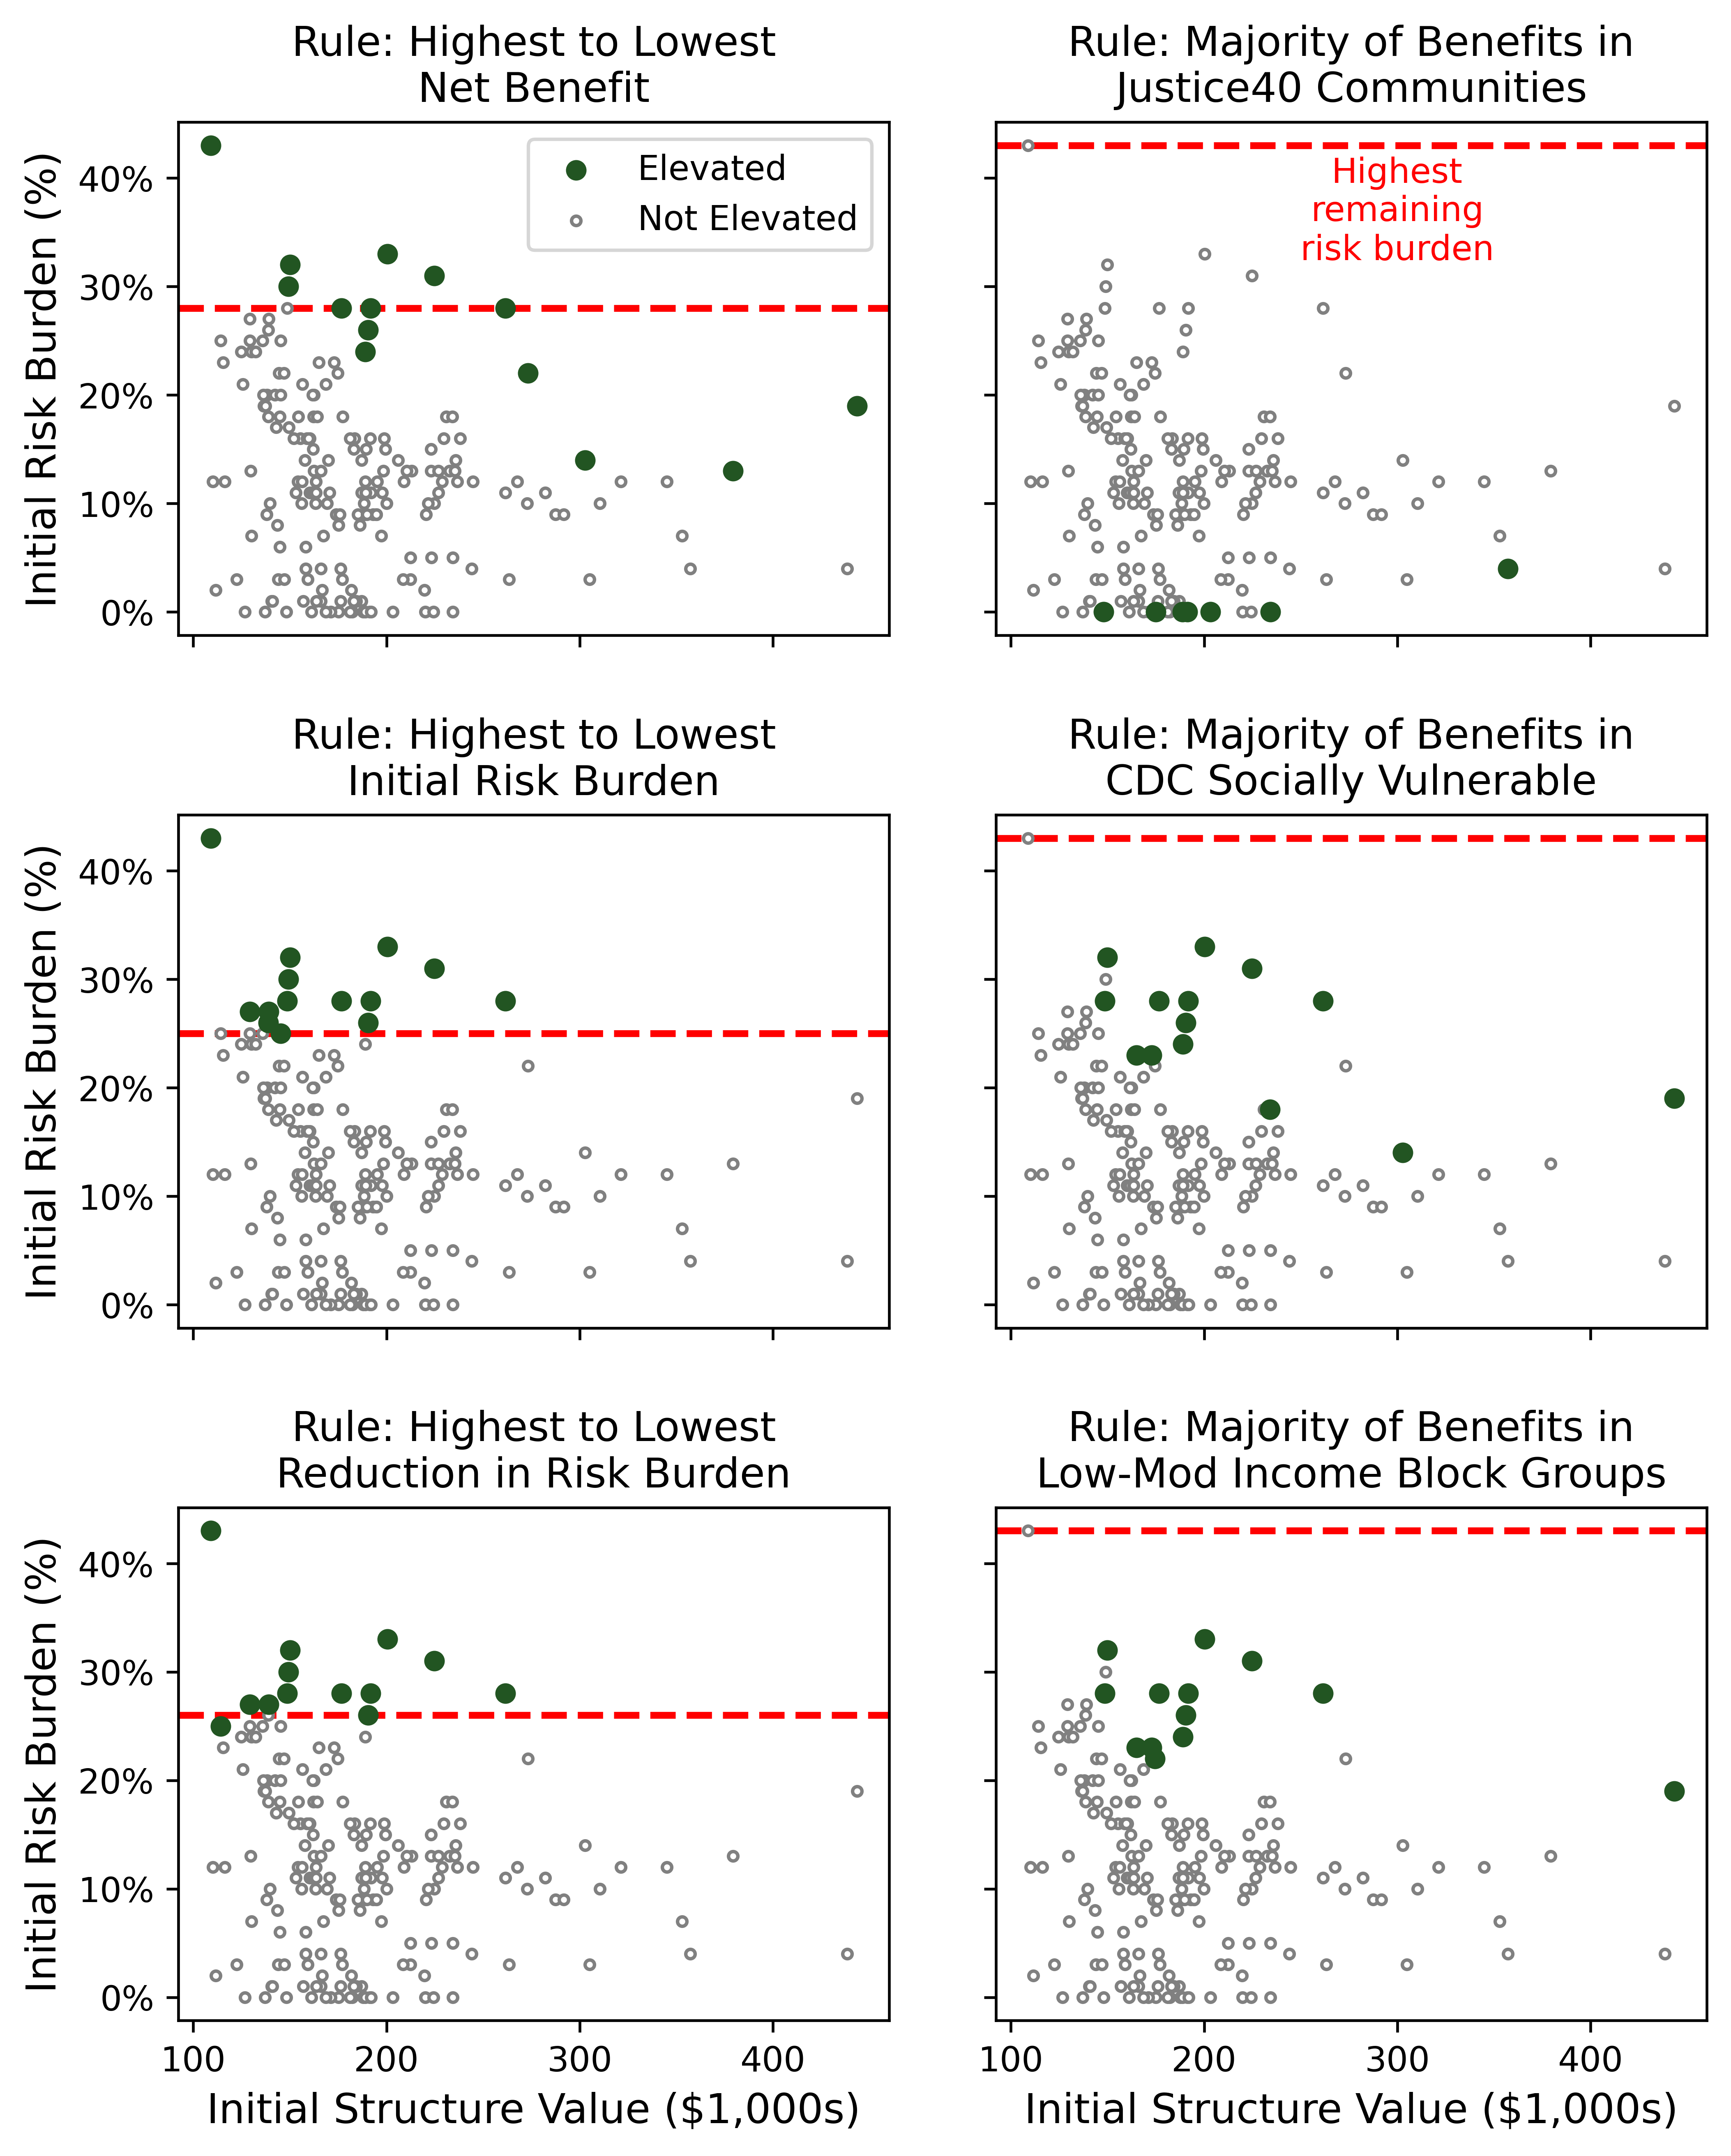

In [9]:
scen = 'Mid'
ens_plot = ens_agg_dfs[scen]

budget = 2e6

title_dict = {
    'lmi': 'Rule: Majority of Benefits in\nLow-Mod Income Block Groups',
    'npv_opt': 'Rule: Highest to Lowest\nNet Benefit' ,
    'sovi': 'Rule: Majority of Benefits in\nCDC Socially Vulnerable',
    'rel_eal': 'Rule: Highest to Lowest\nInitial Risk Burden',
    'cejst': 'Rule: Majority of Benefits in\nJustice40 Communities',
    'avoid_rel_eal': 'Rule: Highest to Lowest\nReduction in Risk Burden'
}

sort_cols = ['npv_opt',
             'cejst', 
             'rel_eal',
             'sovi',
             'avoid_rel_eal',
             'lmi']

color_dict = {
    'sovi': "#33BBEE",
    'lmi': "#0077BB",
    'cejst': "#009988",
    'avoid_rel_eal': "#EE3377",
    'rel_eal': "#CC3311",
    'npv_opt': "#EE7733",
}

fig, ax = plt.subplots(
        figsize=(8, 10),
        nrows=3,
        ncols=2,
        dpi=600,
        sharey=True,
        sharex=True,
        gridspec_kw={"wspace": 0.15, "hspace": 0.35},
    )

# Some preprocessing to help the plotting look nicer
# get structural value in thousands
ens_plot["val_s_thou"] = ens_plot["val_s"] / 1e3
# get the rel_eal_plot columns
ens_plot["rel_eal_plot"] = np.round(ens_plot["rel_eal"] * 100)
ens_plot["resid_rel_eal_plot"] = np.round(ens_plot["resid_rel_eal"] * 100)

for i, sort in enumerate(sort_cols):
    col = i % 2
    row = i // 2

    # Find the policy
    policy = sort + "_" + str(budget)
    fd_ids = elev_ids["Mid_" + policy]

    # Subset into homes that are elevated for this policy
    elevated = ens_plot.loc[ens_plot["fd_id"].isin(fd_ids)]
    not_elev = ens_plot.loc[~ens_plot["fd_id"].isin(fd_ids)]

    # Plot a vertical line that goes through the highest
    # remaining risk burden
    ax[row, col].axhline(not_elev['rel_eal_plot'].max(),
                         color='red',
                         lw=2,
                         alpha=1,
                         zorder=0,
                         ls='--')

    # Plot the initial risk burden plot
    # We'll use the size/2 so that the points
    # which aren't elevated don't show as prominently
    # We'll also plot them first so that they are below the
    # elevated points
    not_elev.plot(
        x="val_s_thou",
        y="rel_eal_plot",
        kind="scatter",
        edgecolor="gray",
        color="white",
        label="Not Elevated",
        s=15 / 2,
        ax=ax[row, col],
    )
    # We'll plot these in the green #225522 so they stand out
    elevated.plot(
        x="val_s_thou",
        y="rel_eal_plot",
        kind="scatter",
        color="#225522",
        label="Elevated",
        s=25,
        ax=ax[row, col],
    )
    # Add title
    ax[row, col].set_title(title_dict[sort], size=12)

    # Clean up the plot
    # Remove left ticks from each axis in column 1
    # ax[row, 1].tick_params(axis='both',
    #                        which='both',
    #                        left=False)
    # Remove bottom ticks from each axis in row 1
    ax[0, col].tick_params(axis="both", which="both")
    ax[row, 0].set_ylabel("Initial Risk Burden (%)", size=12)
    ax[row, 0].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    ax[2, col].set_xlabel("Initial Structure Value ($1,000s)", size=12)

ax[0, 1].get_legend().remove()
ax[1, 1].get_legend().remove()
ax[1, 0].get_legend().remove()
ax[2, 1].get_legend().remove()
ax[2, 0].get_legend().remove()

# Annotate top right plot
ax[0, 1].annotate("Highest\nremaining\nrisk burden", 
                  xy=(300, 32.5), xytext=(300, 32.5),
                  color="red",
                  ha="center",
                  )

# Update labels
handles, labels = ax[0, 0].get_legend_handles_labels()
ax[0, 0].legend(handles[::-1], labels[::-1], ncols=1,
                loc='upper right')

save_filename = join(FIG_DIR, 'Figure3',
                     scen + '_budget_' +
                     str(budget)[0] + 'e6_.png')
unfile.prepare_saving(save_filename)
fig.savefig(save_filename)

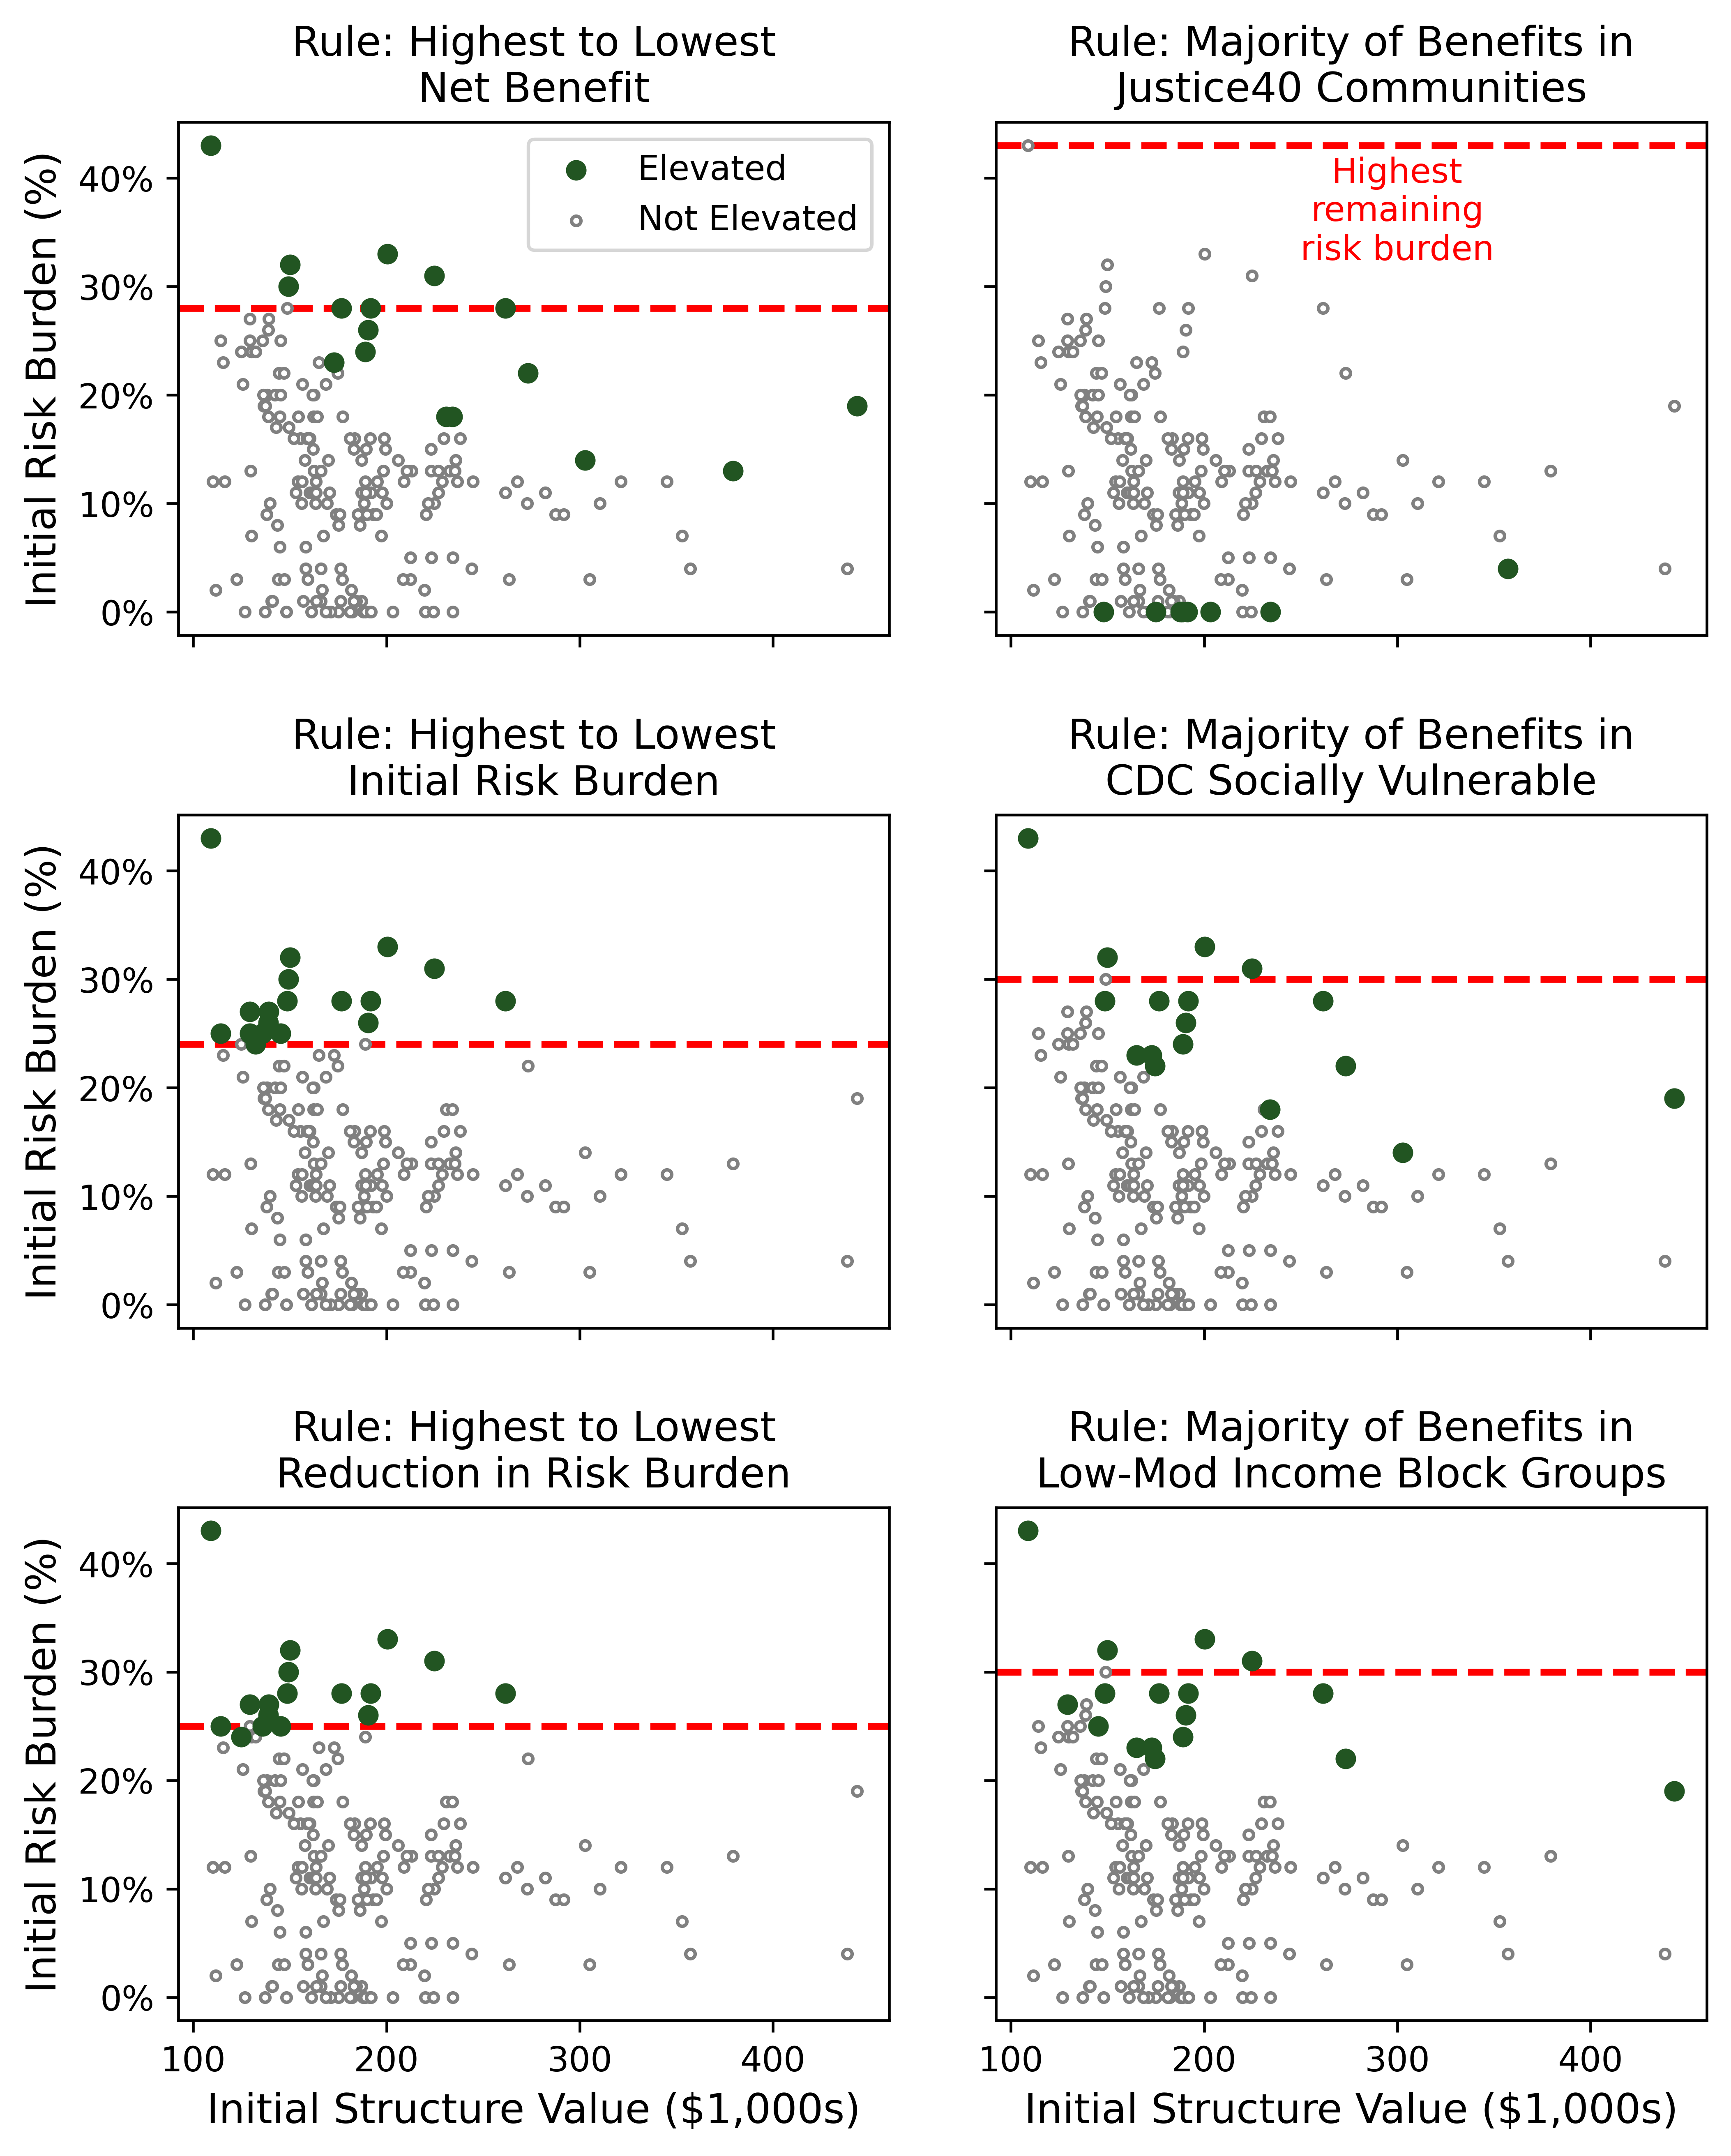

In [10]:
scen = 'Mid'
ens_plot = ens_agg_dfs[scen]

budget = 2.5e6

title_dict = {
    'lmi': 'Rule: Majority of Benefits in\nLow-Mod Income Block Groups',
    'npv_opt': 'Rule: Highest to Lowest\nNet Benefit' ,
    'sovi': 'Rule: Majority of Benefits in\nCDC Socially Vulnerable',
    'rel_eal': 'Rule: Highest to Lowest\nInitial Risk Burden',
    'cejst': 'Rule: Majority of Benefits in\nJustice40 Communities',
    'avoid_rel_eal': 'Rule: Highest to Lowest\nReduction in Risk Burden'
}

sort_cols = ['npv_opt',
             'cejst', 
             'rel_eal',
             'sovi',
             'avoid_rel_eal',
             'lmi']

color_dict = {
    'sovi': "#33BBEE",
    'lmi': "#0077BB",
    'cejst': "#009988",
    'avoid_rel_eal': "#EE3377",
    'rel_eal': "#CC3311",
    'npv_opt': "#EE7733",
}

fig, ax = plt.subplots(
        figsize=(8, 10),
        nrows=3,
        ncols=2,
        dpi=600,
        sharey=True,
        sharex=True,
        gridspec_kw={"wspace": 0.15, "hspace": 0.35},
    )

# Some preprocessing to help the plotting look nicer
# get structural value in thousands
ens_plot["val_s_thou"] = ens_plot["val_s"] / 1e3
# get the rel_eal_plot columns
ens_plot["rel_eal_plot"] = np.round(ens_plot["rel_eal"] * 100)
ens_plot["resid_rel_eal_plot"] = np.round(ens_plot["resid_rel_eal"] * 100)

for i, sort in enumerate(sort_cols):
    col = i % 2
    row = i // 2

    # Find the policy
    policy = sort + "_" + str(budget)
    fd_ids = elev_ids["Mid_" + policy]

    # Subset into homes that are elevated for this policy
    elevated = ens_plot.loc[ens_plot["fd_id"].isin(fd_ids)]
    not_elev = ens_plot.loc[~ens_plot["fd_id"].isin(fd_ids)]

    # Plot a vertical line that goes through the highest
    # remaining risk burden
    ax[row, col].axhline(not_elev['rel_eal_plot'].max(),
                         color='red',
                         lw=2,
                         alpha=1,
                         zorder=0,
                         ls='--')

    # Plot the initial risk burden plot
    # We'll use the size/2 so that the points
    # which aren't elevated don't show as prominently
    # We'll also plot them first so that they are below the
    # elevated points
    not_elev.plot(
        x="val_s_thou",
        y="rel_eal_plot",
        kind="scatter",
        edgecolor="gray",
        color="white",
        label="Not Elevated",
        s=15 / 2,
        ax=ax[row, col],
    )
    # We'll plot these in the green #225522 so they stand out
    elevated.plot(
        x="val_s_thou",
        y="rel_eal_plot",
        kind="scatter",
        color="#225522",
        label="Elevated",
        s=25,
        ax=ax[row, col],
    )
    # Add title
    ax[row, col].set_title(title_dict[sort], size=12)

    # Clean up the plot
    # Remove left ticks from each axis in column 1
    # ax[row, 1].tick_params(axis='both',
    #                        which='both',
    #                        left=False)
    # Remove bottom ticks from each axis in row 1
    ax[0, col].tick_params(axis="both", which="both")
    ax[row, 0].set_ylabel("Initial Risk Burden (%)", size=12)
    ax[row, 0].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    ax[2, col].set_xlabel("Initial Structure Value ($1,000s)", size=12)

ax[0, 1].get_legend().remove()
ax[1, 1].get_legend().remove()
ax[1, 0].get_legend().remove()
ax[2, 1].get_legend().remove()
ax[2, 0].get_legend().remove()

# Annotate top right plot
ax[0, 1].annotate("Highest\nremaining\nrisk burden", 
                  xy=(300, 32.5), xytext=(300, 32.5),
                  color="red",
                  ha="center",
                  )

# Update labels
handles, labels = ax[0, 0].get_legend_handles_labels()
ax[0, 0].legend(handles[::-1], labels[::-1], ncols=1,
                loc='upper right')

save_filename = join(FIG_DIR, 'Figure3',
                     scen + '_budget_' +
                     str(budget)[0] + 'e6_.png')
unfile.prepare_saving(save_filename)
fig.savefig(save_filename)

In [ ]:
# Ovb w/ $1M budget
scen = 'Mid'
ens_plot = ens_agg_dfs[scen]

budget = 1e6

title_dict = {
    'lmi': 'Rule: Majority of Benefits in\nLow-Mod Income Block Groups',
    'npv_opt': 'Rule: Highest to Lowest\nNet Benefit' ,
    'sovi': 'Rule: Majority of Benefits in\nCDC Socially Vulnerable',
    'rel_eal': 'Rule: Highest to Lowest\nInitial Risk Burden',
    'ovb': 'Rule: Majority of Benefits in\nNJ Overburdened',
    'avoid_rel_eal': 'Rule: Highest to Lowest\nReduction in Risk Burden'
}

sort_cols = ['npv_opt',
             'ovb', 
             'rel_eal',
             'sovi',
             'avoid_rel_eal',
             'lmi']

color_dict = {
    'sovi': "#33BBEE",
    'lmi': "#0077BB",
    'ovb': "#009988",
    'avoid_rel_eal': "#EE3377",
    'rel_eal': "#CC3311",
    'npv_opt': "#EE7733",
}

fig, ax = plt.subplots(
        figsize=(8, 10),
        nrows=3,
        ncols=2,
        dpi=600,
        sharey=True,
        sharex=True,
        gridspec_kw={"wspace": 0.15, "hspace": 0.35},
    )

# Some preprocessing to help the plotting look nicer
# get structural value in thousands
ens_plot["val_s_thou"] = ens_plot["val_s"] / 1e3
# get the rel_eal_plot columns
ens_plot["rel_eal_plot"] = np.round(ens_plot["rel_eal"] * 100)
ens_plot["resid_rel_eal_plot"] = np.round(ens_plot["resid_rel_eal"] * 100)

for i, sort in enumerate(sort_cols):
    col = i % 2
    row = i // 2

    # Find the policy
    policy = sort + "_" + str(budget)
    fd_ids = elev_ids["Mid_" + policy]

    # Subset into homes that are elevated for this policy
    elevated = ens_plot.loc[ens_plot["fd_id"].isin(fd_ids)]
    not_elev = ens_plot.loc[~ens_plot["fd_id"].isin(fd_ids)]

    # Plot a vertical line that goes through the highest
    # remaining risk burden
    ax[row, col].axhline(not_elev['rel_eal_plot'].max(),
                         color='red',
                         lw=2,
                         alpha=1,
                         zorder=0,
                         ls='--')

    # Plot the initial risk burden plot
    # We'll use the size/2 so that the points
    # which aren't elevated don't show as prominently
    # We'll also plot them first so that they are below the
    # elevated points
    not_elev.plot(
        x="val_s_thou",
        y="rel_eal_plot",
        kind="scatter",
        edgecolor="gray",
        color="white",
        label="Not Elevated",
        s=15 / 2,
        ax=ax[row, col],
    )
    # We'll plot these in the green #225522 so they stand out
    elevated.plot(
        x="val_s_thou",
        y="rel_eal_plot",
        kind="scatter",
        color="#225522",
        label="Elevated",
        s=25,
        ax=ax[row, col],
    )
    # Add title
    ax[row, col].set_title(title_dict[sort], size=12)

    # Clean up the plot
    # Remove bottom ticks from each axis in row 1
    ax[0, col].tick_params(axis="both", which="both")
    ax[row, 0].set_ylabel("Initial Risk Burden (%)", size=12)
    ax[row, 0].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    ax[2, col].set_xlabel("Initial Structure Value ($1,000s)", size=12)

ax[0, 1].get_legend().remove()
ax[1, 1].get_legend().remove()
ax[1, 0].get_legend().remove()
ax[2, 1].get_legend().remove()
ax[2, 0].get_legend().remove()

# Annotate top left plot
ax[0, 0].annotate("Highest\nremaining\nrisk burden", 
                  xy=(148, 33), xytext=(148, 33),
                  color="red",
                  ha="center",
                  )

# Update labels
handles, labels = ax[0, 0].get_legend_handles_labels()
ax[0, 0].legend(handles[::-1], labels[::-1], ncols=1)

save_filename = join(FIG_DIR, 'Figure3',
                     scen + '_budget_' +
                     str(budget)[0] + 'e6_ovb.png')
unfile.prepare_saving(save_filename)
fig.savefig(save_filename)

In [ ]:
# OVB w/ $2.5M budget
scen = 'Mid'
ens_plot = ens_agg_dfs[scen]

budget = 2.5e6

title_dict = {
    'lmi': 'Rule: Majority of Benefits in\nLow-Mod Income Block Groups',
    'npv_opt': 'Rule: Highest to Lowest\nNet Benefit' ,
    'sovi': 'Rule: Majority of Benefits in\nCDC Socially Vulnerable',
    'rel_eal': 'Rule: Highest to Lowest\nInitial Risk Burden',
    'ovb': 'Rule: Majority of Benefits in\nNJ Overburdened',
    'avoid_rel_eal': 'Rule: Highest to Lowest\nReduction in Risk Burden'
}

sort_cols = ['npv_opt',
             'ovb', 
             'rel_eal',
             'sovi',
             'avoid_rel_eal',
             'lmi']

color_dict = {
    'sovi': "#33BBEE",
    'lmi': "#0077BB",
    'ovb': "#009988",
    'avoid_rel_eal': "#EE3377",
    'rel_eal': "#CC3311",
    'npv_opt': "#EE7733",
}

fig, ax = plt.subplots(
        figsize=(8, 10),
        nrows=3,
        ncols=2,
        dpi=600,
        sharey=True,
        sharex=True,
        gridspec_kw={"wspace": 0.15, "hspace": 0.35},
    )

# Some preprocessing to help the plotting look nicer
# get structural value in thousands
ens_plot["val_s_thou"] = ens_plot["val_s"] / 1e3
# get the rel_eal_plot columns
ens_plot["rel_eal_plot"] = np.round(ens_plot["rel_eal"] * 100)
ens_plot["resid_rel_eal_plot"] = np.round(ens_plot["resid_rel_eal"] * 100)

for i, sort in enumerate(sort_cols):
    col = i % 2
    row = i // 2

    # Find the policy
    policy = sort + "_" + str(budget)
    fd_ids = elev_ids["Mid_" + policy]

    # Subset into homes that are elevated for this policy
    elevated = ens_plot.loc[ens_plot["fd_id"].isin(fd_ids)]
    not_elev = ens_plot.loc[~ens_plot["fd_id"].isin(fd_ids)]

    # Plot a vertical line that goes through the highest
    # remaining risk burden
    ax[row, col].axhline(not_elev['rel_eal_plot'].max(),
                         color='red',
                         lw=2,
                         alpha=1,
                         zorder=0,
                         ls='--')

    # Plot the initial risk burden plot
    # We'll use the size/2 so that the points
    # which aren't elevated don't show as prominently
    # We'll also plot them first so that they are below the
    # elevated points
    not_elev.plot(
        x="val_s_thou",
        y="rel_eal_plot",
        kind="scatter",
        edgecolor="gray",
        color="white",
        label="Not Elevated",
        s=15 / 2,
        ax=ax[row, col],
    )
    # We'll plot these in the green #225522 so they stand out
    elevated.plot(
        x="val_s_thou",
        y="rel_eal_plot",
        kind="scatter",
        color="#225522",
        label="Elevated",
        s=25,
        ax=ax[row, col],
    )
    # Add title
    ax[row, col].set_title(title_dict[sort], size=12)

    # Clean up the plot
    # Remove bottom ticks from each axis in row 1
    ax[0, col].tick_params(axis="both", which="both")
    ax[row, 0].set_ylabel("Initial Risk Burden (%)", size=12)
    ax[row, 0].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    ax[2, col].set_xlabel("Initial Structure Value ($1,000s)", size=12)

ax[0, 1].get_legend().remove()
ax[1, 1].get_legend().remove()
ax[1, 0].get_legend().remove()
ax[2, 1].get_legend().remove()
ax[2, 0].get_legend().remove()

# Annotate top left plot
ax[0, 0].annotate("Highest\nremaining\nrisk burden", 
                  xy=(350, 15), xytext=(350, 15),
                  color="red",
                  ha="center",
                  )

# Update labels
handles, labels = ax[0, 0].get_legend_handles_labels()
ax[0, 0].legend(handles[::-1], labels[::-1], ncols=1)

save_filename = join(FIG_DIR, 'Figure3',
                     scen + '_budget_' +
                     str(budget)[0] + 'e6_ovb.png')
unfile.prepare_saving(save_filename)
fig.savefig(save_filename)

## Figure 4 supplementary

In [ ]:
def risk_val_gini(risk, val):
    risk = np.asarray(risk)
    val = np.asarray(val)
    # Sort both by ascending value index
    # and store the cumulative sum
    sorted_indices = np.argsort(val)
    sorted_risk = risk[sorted_indices].cumsum()
    population = np.arange(0, len(risk) + 1)/len(risk)
    # Normalize risk
    risk_norm = sorted_risk/sorted_risk.max()
    # Insert 0 for each
    risk_norm = np.insert(0., 1, risk_norm)
    # Calculate gini
    gini = np.abs((np.diff(population))*((risk_norm + np.roll(risk_norm, shift=1))[1:]/2) -
                  (np.diff(population)*(population + np.roll(population, shift=1))[1:]/2)).sum()/.5
    return gini

In [ ]:
# OVB
scen = 'Mid'

ens_filep = join(FO, 'ensemble_' + scen + '.pqt')
ens_df = pd.read_parquet(ens_filep)
eal_col = 'eal'
ens_df['rel_eal'] = ens_df[eal_col]/ens_df['val_s']

ens_df = ens_df[~ens_df['fd_id'].isin(drop_ids)]

ens_plot = ens_agg_dfs[scen]
objs_plot = objs[(objs['sort'] != 'cejst') &
                 (objs['budget'] <= 3e6) &
                 (objs['scen'] == scen)]

sort_cols = ['npv_opt',
             'ovb', 
             'lmi',
             'sovi',
             'rel_eal',
             'avoid_rel_eal']

color_dict = {
    'CDC Socially Vulnerable': "#33BBEE",
    'Low-Mod Income': "#0077BB",
    'NJ Overburdened': "#009988",
    'Risk Burden Reduction': "#EE3377",
    'Initial Risk Burden': "#CC3311",
    'Net Benefit': "#EE7733",
}

sort_dict = {
    'ovb': 'NJ Overburdened',
    'lmi': 'Low-Mod Income',
    'sovi': 'CDC Socially Vulnerable',
    'npv_opt': 'Net Benefit',
    'rel_eal': 'Initial Risk Burden',
    'avoid_rel_eal': 'Risk Burden Reduction'
}

order_dict = {
    'ovb': 0,
    'lmi': 1,
    'sovi': 2,
    'npv_opt': 3,
    'rel_eal': 4,
    'avoid_rel_eal': 5
}

markers_dict = {
    'CDC Socially Vulnerable': "X",
    'Low-Mod Income': "D",
    'NJ Overburdened': "s",
    'Risk Burden Reduction': "o",
    'Initial Risk Burden': "P",
    'Net Benefit': "v",
}

# Prep plot colums
objs_plot["Funding Rule"] = objs_plot['sort'].map(sort_dict)
objs_plot["order"] = objs_plot['sort'].map(order_dict)
objs_plot = objs_plot.sort_values(['order', 'budget'])

# Plot the initial inequality 
# Lorenz using the mean values
ens_agg_gini = ens_df.sort_values(by=['sow_ind', 'val_s'], ascending=True)
ens_agg_gini['rel_eal_c'] = ens_agg_gini.groupby('sow_ind')['rel_eal'].cumsum()
ens_agg_gini['initial_sum'] = ens_agg_gini.groupby('sow_ind')['rel_eal_c'].transform(lambda x: x.max())
ens_agg_gini['initial_share'] = ens_agg_gini['rel_eal_c']/ens_agg_gini['initial_sum']
ens_agg_gini['population'] = ens_agg_gini.groupby('sow_ind').cumcount()
# Get the average initial_share values for each structure
ens_agg_gini = ens_agg_gini.groupby('population')['initial_share'].mean().reset_index()
# Get the population index
population = np.arange(0, len(ens_agg_gini))/len(ens_agg_gini)

# Gini using expected value from ensemble
gini_init = ens_df.groupby('sow_ind').apply(lambda x: risk_val_gini(x['rel_eal'],
                                                                    x['val_s'])).mean()
gini_plot = str(np.round(gini_init, 2))
    
# Now plot a big panel building intuition 
# about the Lorenz curve
# and the gini index
from matplotlib.gridspec import GridSpec
fig = plt.figure(layout="constrained",
                 figsize=(8, 8),
                 dpi=600)
gs = GridSpec(2, 1, figure=fig,
              height_ratios=[3, 2],
              hspace=.05)
ax1 = fig.add_subplot(gs[0])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1])

ax1.plot(population,
         ens_agg_gini['initial_share'],
              color='#663333',
              lw=2,
              ls='-')
ax1.plot(population,
         population,
        lw=2,
        color='black')

ax1.fill_between(population,
                ens_agg_gini['initial_share'],
                population,
               color='#225522',
               alpha=.5)

ax1.set_xlabel("Share of Population",
              size=14)
ax1.set_ylabel("Share of Overall Risk Burden",
              size=14)
ax1.tick_params(axis="both", which="both", labelsize=14)

ax1.annotate('The initial distribution\nof structure value\nand risk burden has\na Gini Index of ' + gini_plot + '.',
            xy=(.05, .51), xytext=(.05, .51),
            color='#663333',
            size=14)

ax1.annotate('The ideal distribution\nof structure value\nand risk burden has\na Gini Index of 0,\nindicating no relationship\nbetween structure value\nand risk burden.',
            xy=(.66, .15), xytext=(.66, .15),
            color='black',
            size=14)

ax1.annotate('Funding rules that\nlead to a Gini Index\ncloser to 0 are better.',
            xy=(.22, .01), xytext=(.22, .01),
            color='#225522',
            size=14)

# Plot budgets and ginis
objs_plot['cost'] = objs_plot['up_cost']/1e6
objs_plot['budg_plot'] = objs_plot['budget']/1e6
ax2.axhline(gini_init, color='gray', lw=2, ls='dotted',
            zorder=0)

sns.lineplot(
    y='resid_eq',
    x='budg_plot',
    data=objs_plot,
    hue="Funding Rule",
    palette=color_dict,
    # lw=lw,
    legend=False,
    ls='dotted',
    alpha=.25,
    ax=ax2,
)

sns.scatterplot(x="budg_plot",
            y='resid_eq',
            data=objs_plot,
            hue="Funding Rule",
            palette=color_dict,
            style="Funding Rule",
            alpha=.75,
            markers=markers_dict,
            lw=0,
            edgecolor='none',
            s=100,
            legend=False,
            ax=ax2,)


ax2.set_xticks([1, 1.5, 2, 2.5, 3])
ax2.tick_params(labelsize=14)
ax2.set_ylabel('Risk-Burden Inequality', size=14)
ax2.set_xlabel('Budget ($M)', size=14)

# Add legend below
lw=2
legend_elements = [
        Line2D([0], [0], color="black", ls="none", label="Household Rules"),
        Line2D([0], [0], color=color_dict["Net Benefit"],
               marker=markers_dict["Net Benefit"],
               markersize=10,
               ls='none',
               lw=lw, label="Net Benefit"),
        Line2D(
            [0],
            [0],
            color=color_dict["Risk Burden Reduction"],
            marker=markers_dict["Risk Burden Reduction"],
            markersize=10,
            lw=lw,
            ls='none',
            label="Risk Burden Reduction",
        ),
        Line2D(
            [0], [0], color=color_dict["Initial Risk Burden"],
            marker=markers_dict["Initial Risk Burden"],
            markersize=10,
            ls='none',
            lw=lw, label="Initial Risk Burden"
        ),
        Line2D([0], [0], color="black", ls="none", label="Community Rules"),
        Line2D(
            [0],
            [0],
            color=color_dict["Low-Mod Income"],
            marker=markers_dict["Low-Mod Income"],
            markersize=10,
            lw=lw,
            ls="none",
            label="Low-Mod Income",
        ),
        Line2D(
            [0],
            [0],
            color=color_dict["CDC Socially Vulnerable"],
            marker=markers_dict["CDC Socially Vulnerable"],
            markersize=10,
            lw=lw,
            ls="none",
            label="CDC Socially Vulnerable",
        ),
        Line2D(
            [0],
            [0],
            color=color_dict["NJ Overburdened"],
            label="NJ Overburdened",
            marker=markers_dict["NJ Overburdened"],
            markersize=10,
            ls="none",
        ),
    ]

ax2.legend(
        handles=legend_elements,
        loc="center",
        ncol=2,
        fontsize="large",
        bbox_to_anchor=(.5, -0.495),
    )

ax2.annotate('Initial Inequality', 
             size=14,
             xy=(2, .06), xytext=(2, .06),
             color='gray')

fig.align_ylabels()

save_filename = join(FIG_DIR, 'Figure4',
                             scen + '_ovb.png')
unfile.prepare_saving(save_filename)
fig.savefig(save_filename)

In [ ]:
scen = 'Mid'

ens_filep = join(FO, 'ensemble_' + scen + '.pqt')
ens_df = pd.read_parquet(ens_filep)
eal_col = 'eal'
ens_df['rel_eal'] = ens_df[eal_col]/ens_df['val_s']

ens_df = ens_df[~ens_df['fd_id'].isin(drop_ids)]

ens_plot = ens_agg_dfs[scen]
objs_plot = objs[(objs['sort'] != 'ovb') &
                 (objs['scen'] == scen)]

sort_cols = ['npv_opt',
             'cejst', 
             'lmi',
             'sovi',
             'rel_eal',
             'avoid_rel_eal']

color_dict = {
    'CDC Socially Vulnerable': "#33BBEE",
    'Low-Mod Income': "#0077BB",
    'Justice40 (FEMA Now)': "#009988",
    'Risk Burden Reduction': "#EE3377",
    'Initial Risk Burden': "#CC3311",
    'Net Benefit': "#EE7733",
}

sort_dict = {
    'cejst': 'Justice40 (FEMA Now)',
    'lmi': 'Low-Mod Income',
    'sovi': 'CDC Socially Vulnerable',
    'npv_opt': 'Net Benefit',
    'rel_eal': 'Initial Risk Burden',
    'avoid_rel_eal': 'Risk Burden Reduction'
}

order_dict = {
    'cejst': 0,
    'lmi': 1,
    'sovi': 2,
    'npv_opt': 3,
    'rel_eal': 4,
    'avoid_rel_eal': 5
}

markers_dict = {
    'CDC Socially Vulnerable': "X",
    'Low-Mod Income': "D",
    'Justice40 (FEMA Now)': "s",
    'Risk Burden Reduction': "o",
    'Initial Risk Burden': "P",
    'Net Benefit': "v",
}

# Prep plot colums
objs_plot["Funding Rule"] = objs_plot['sort'].map(sort_dict)
objs_plot["order"] = objs_plot['sort'].map(order_dict)
objs_plot = objs_plot.sort_values(['order', 'budget'])

# Plot the initial inequality 
# Lorenz using the mean values
ens_agg_gini = ens_df.sort_values(by=['sow_ind', 'val_s'], ascending=True)
ens_agg_gini['rel_eal_c'] = ens_agg_gini.groupby('sow_ind')['rel_eal'].cumsum()
ens_agg_gini['initial_sum'] = ens_agg_gini.groupby('sow_ind')['rel_eal_c'].transform(lambda x: x.max())
ens_agg_gini['initial_share'] = ens_agg_gini['rel_eal_c']/ens_agg_gini['initial_sum']
ens_agg_gini['population'] = ens_agg_gini.groupby('sow_ind').cumcount()
# Get the average initial_share values for each structure
ens_agg_gini = ens_agg_gini.groupby('population')['initial_share'].mean().reset_index()
# Get the population index
population = np.arange(0, len(ens_agg_gini))/len(ens_agg_gini)

# Gini using expected value from ensemble
gini_init = ens_df.groupby('sow_ind').apply(lambda x: risk_val_gini(x['rel_eal'],
                                                                    x['val_s'])).mean()
gini_plot = str(np.round(gini_init, 2))
    
# Now plot a big panel building intuition 
# about the Lorenz curve
# and the gini index
from matplotlib.gridspec import GridSpec
fig = plt.figure(layout="constrained",
                 figsize=(8, 8),
                 dpi=600)
gs = GridSpec(2, 1, figure=fig,
              height_ratios=[3, 2],
              hspace=.05)
ax1 = fig.add_subplot(gs[0])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1])

ax1.plot(population,
         ens_agg_gini['initial_share'],
              color='#663333',
              lw=2,
              ls='-')
ax1.plot(population,
         population,
        lw=2,
        color='black')

ax1.fill_between(population,
                ens_agg_gini['initial_share'],
                population,
               color='#225522',
               alpha=.5)

ax1.set_xlabel("Share of Population",
              size=14)
ax1.set_ylabel("Share of Overall Risk Burden",
              size=14)
ax1.tick_params(axis="both", which="both", labelsize=14)

ax1.annotate('The initial distribution\nof structure value\nand risk burden has\na Gini Index of ' + gini_plot + '.',
            xy=(.05, .51), xytext=(.05, .51),
            color='#663333',
            size=14)

ax1.annotate('The ideal distribution\nof structure value\nand risk burden has\na Gini Index of 0,\nindicating no relationship\nbetween structure value\nand risk burden.',
            xy=(.66, .15), xytext=(.66, .15),
            color='black',
            size=14)

ax1.annotate('Funding rules that\nlead to a Gini Index\ncloser to 0 are better.',
            xy=(.22, .01), xytext=(.22, .01),
            color='#225522',
            size=14)

# Plot budgets and ginis
objs_plot['cost'] = objs_plot['up_cost']/1e6
objs_plot['budget_plot'] = objs_plot['budget']/1e6
ax2.axhline(gini_init, color=
            'gray', lw=2, ls='dotted',
            zorder=0)

sns.lineplot(
        y='resid_eq',
        x='budget_plot',
        data=objs_plot,
        hue="Funding Rule",
        palette=color_dict,
        # lw=lw,
        legend=False,
        ls='dotted',
        alpha=.25,
        ax=ax2,
    )

sns.scatterplot(x="budget_plot",
            y='resid_eq',
            data=objs_plot,
            hue="Funding Rule",
            palette=color_dict,
            style="Funding Rule",
            alpha=.75,
            markers=markers_dict,
            lw=0,
            edgecolor='none',
            s=100,
            legend=False,
            ax=ax2,)

ax2.tick_params(labelsize=14)
ax2.set_ylabel('Risk-Burden Inequality', size=14)
ax2.set_xlabel('Budget ($M)', size=14)

# Add legend below
lw=2
legend_elements = [
        Line2D([0], [0], color="black", ls="none", label="Household Rules"),
        Line2D([0], [0], color=color_dict["Net Benefit"],
               marker=markers_dict["Net Benefit"],
               markersize=10,
               ls='none',
               lw=lw, label="Net Benefit"),
        Line2D(
            [0],
            [0],
            color=color_dict["Risk Burden Reduction"],
            marker=markers_dict["Risk Burden Reduction"],
            markersize=10,
            lw=lw,
            ls='none',
            label="Risk Burden Reduction",
        ),
        Line2D(
            [0], [0], color=color_dict["Initial Risk Burden"],
            marker=markers_dict["Initial Risk Burden"],
            markersize=10,
            ls='none',
            lw=lw, label="Initial Risk Burden"
        ),
        Line2D([0], [0], color="black", ls="none", label="Community Rules"),
        Line2D(
            [0],
            [0],
            color=color_dict["Low-Mod Income"],
            marker=markers_dict["Low-Mod Income"],
            markersize=10,
            lw=lw,
            ls="none",
            label="Low-Mod Income",
        ),
        Line2D(
            [0],
            [0],
            color=color_dict["CDC Socially Vulnerable"],
            marker=markers_dict["CDC Socially Vulnerable"],
            markersize=10,
            lw=lw,
            ls="none",
            label="CDC Socially Vulnerable",
        ),
        Line2D(
            [0],
            [0],
            color=color_dict["Justice40 (FEMA Now)"],
            label="Justice40 (FEMA Now)",
            marker=markers_dict["Justice40 (FEMA Now)"],
            markersize=10,
            ls="none",
        ),
    ]

ax2.legend(
        handles=legend_elements,
        loc="center",
        ncol=2,
        fontsize="large",
        bbox_to_anchor=(.5, -0.495),
    )

ax2.annotate('Initial Inequality', 
             size=14,
             xy=(9.5, .05), xytext=(9.5, .05),
             color='gray')

fig.align_ylabels()

save_filename = join(FIG_DIR, 'Figure4',
                             scen + '_sensitivity.png')
unfile.prepare_saving(save_filename)
fig.savefig(save_filename)

In [ ]:
# 3 panel figure comparing Lower, Mid, Upper ginis across upfront cost
color_dict = {
    'CDC Socially Vulnerable': "#33BBEE",
    'Low-Mod Income': "#0077BB",
    'Justice40 (FEMA Now)': "#009988",
    'Risk Burden Reduction': "#EE3377",
    'Initial Risk Burden': "#CC3311",
    'Net Benefit': "#EE7733",
}

sort_dict = {
    'cejst': 'Justice40 (FEMA Now)',
    'lmi': 'Low-Mod Income',
    'sovi': 'CDC Socially Vulnerable',
    'npv_opt': 'Net Benefit',
    'rel_eal': 'Initial Risk Burden',
    'avoid_rel_eal': 'Risk Burden Reduction'
}

order_dict = {
    'cejst': 0,
    'lmi': 1,
    'sovi': 2,
    'npv_opt': 3,
    'rel_eal': 4,
    'avoid_rel_eal': 5
}

markers_dict = {
    'CDC Socially Vulnerable': "X",
    'Low-Mod Income': "D",
    'Justice40 (FEMA Now)': "s",
    'Risk Burden Reduction': "o",
    'Initial Risk Burden': "P",
    'Net Benefit': "v",
}
    
# Now plot a big panel building intuition 
# about the Lorenz curve
# and the gini index
fig, ax = plt.subplots(figsize=(8, 8),
                       nrows=3,
                       sharex=True,
                       sharey=True,
                       dpi=600)

for i, scen in enumerate(SCENARIOS):
    scenario = scen 

    ens_filep = join(FO, 'ensemble_' + scen + '.pqt')
    ens_df = pd.read_parquet(ens_filep)
    eal_col = 'eal'
    ens_df['rel_eal'] = ens_df[eal_col]/ens_df['val_s']
    ens_df = ens_df[~ens_df['fd_id'].isin(drop_ids)]

    ens_plot = ens_agg_dfs[scen]
    objs_plot = objs[(objs['sort'] != 'ovb') &
                     (objs['budget'] < 7e6) &
                     (objs['scen'] == scen)]

    # Prep plot colums
    objs_plot["Funding Rule"] = objs_plot['sort'].map(sort_dict)
    objs_plot["order"] = objs_plot['sort'].map(order_dict)
    objs_plot = objs_plot.sort_values(['order', 'budget'])

    # Gini using expected value from ensemble
    gini_init = ens_df.groupby('sow_ind').apply(lambda x: risk_val_gini(x['rel_eal'],
                                                                        x['val_s'])).mean() 

    ax[i].set_title('Hazard Scenario: ' + scen, size=14)


    # Plot budgets and ginis
    objs_plot['cost'] = objs_plot['up_cost']/1e6
    objs_plot['b_plot'] = objs_plot['budget']/1e6
    ax[i].axhline(gini_init, color='gray', lw=2, ls='dotted',
                zorder=0)
    
    sns.lineplot(
        y='resid_eq',
        x='b_plot',
        data=objs_plot,
        hue="Funding Rule",
        palette=color_dict,
        # lw=lw,
        legend=False,
        ls='dotted',
        alpha=.25,
        ax=ax[i],
    )

    sns.scatterplot(x="b_plot",
                y='resid_eq',
                data=objs_plot,
                hue="Funding Rule",
                palette=color_dict,
                style="Funding Rule",
                alpha=.75,
                markers=markers_dict,
                lw=0,
                edgecolor='none',
                s=100,
                legend=False,
                ax=ax[i],)

    ax[i].set_xticks([1, 2, 3, 4, 5, 6])
    ax[i].tick_params(labelsize=14)
    if i == 1:
        ax[1].set_ylabel('Risk-Burden Inequality', size=14)
    else:
        ax[i].set_ylabel('')
    
    ax[i].set_xlabel('Budget ($M)', size=14)

    
# Add legend below
legend_elements = [
        Line2D([0], [0], color="black", ls="none", label="Household Rules"),
        Line2D([0], [0], color=color_dict["Net Benefit"],
               marker=markers_dict["Net Benefit"],
               markersize=10,
               ls='none',
               label="Net Benefit"),
        Line2D(
            [0],
            [0],
            color=color_dict["Risk Burden Reduction"],
            marker=markers_dict["Risk Burden Reduction"],
            markersize=10,
            ls='none',
            label="Risk Burden Reduction",
        ),
        Line2D(
            [0], [0], color=color_dict["Initial Risk Burden"],
            marker=markers_dict["Initial Risk Burden"],
            markersize=10,
            ls='none',
            label="Initial Risk Burden"
        ),
        Line2D([0], [0], color="black", ls="none", label="Community Rules"),
        Line2D(
            [0],
            [0],
            color=color_dict["Low-Mod Income"],
            marker=markers_dict["Low-Mod Income"],
            markersize=10,
            ls="none",
            label="Low-Mod Income",
        ),
        Line2D(
            [0],
            [0],
            color=color_dict["CDC Socially Vulnerable"],
            marker=markers_dict["CDC Socially Vulnerable"],
            markersize=10,
            ls="none",
            label="CDC Socially Vulnerable",
        ),
        Line2D(
            [0],
            [0],
            color=color_dict["Justice40 (FEMA Now)"],
            label="Justice40 (FEMA Now)",
            marker=markers_dict["Justice40 (FEMA Now)"],
            markersize=10,
            ls="none",
        ),
    ]

ax[2].legend(
        handles=legend_elements,
        loc="center",
        ncol=2,
        fontsize="large",
        bbox_to_anchor=(.5, -0.67),
    )

ax[0].annotate('Initial Inequality', 
               size=14,
               xy=(2.3, .05), xytext=(2.3, .05),
               color='gray')

fig.align_ylabels()
fig.tight_layout()

save_filename = join(FIG_DIR, 'Figure4',
                             'hazard_scenarios_sensitivity.png')
unfile.prepare_saving(save_filename)
fig.savefig(save_filename)

## Figure 5 supplementary

In [ ]:
# Show 4 ways of measuring inequity in investment

save_filename = join(FIG_DIR, 'IneqInvest_Sensitivity.png')

color_dict = {
    'CDC Socially Vulnerable': "#33BBEE",
    'Low-Mod Income': "#0077BB",
    'Justice40 (FEMA Now)': "#009988",
    'Risk Burden Reduction': "#EE3377",
    'Initial Risk Burden': "#CC3311",
    'Net Benefit': "#EE7733",
}

sort_dict = {
    'cejst': 'Justice40 (FEMA Now)',
    'lmi': 'Low-Mod Income',
    'sovi': 'CDC Socially Vulnerable',
    'npv_opt': 'Net Benefit',
    'rel_eal': 'Initial Risk Burden',
    'avoid_rel_eal': 'Risk Burden Reduction'
}

order_dict = {
    'cejst': 0,
    'lmi': 1,
    'sovi': 2,
    'npv_opt': 3,
    'rel_eal': 4,
    'avoid_rel_eal': 5
}

markers_dict = {
    'CDC Socially Vulnerable': "X",
    'Low-Mod Income': "D",
    'Justice40 (FEMA Now)': "s",
    'Risk Burden Reduction': "o",
    'Initial Risk Burden': "P",
    'Net Benefit': "v",
}

obj_names = ['Maximum',
             'Median',
             'Sum',
             '95th%ile']


obj_cols = ['avoid_eq1', 'avoid_eq2', 'avoid_eq3', 'avoid_eq4']

min_obj_cols = obj_cols

scenario = 'Mid'

objs_plot = objs[(objs['scen'] == scenario) &
                (objs['sort'] != 'ovb') &
                (objs['budget'] <= 3e6)]

# Prep plot colums
objs_plot["Budget ($M)"] = objs_plot["budget"]/1e6
objs_plot["npv_plot"] = objs_plot["npv"] / 1e6
objs_plot["Funding Rule"] = objs_plot['sort'].map(sort_dict)
objs_plot["order"] = objs_plot['sort'].map(order_dict)
objs_plot = objs_plot.sort_values(['order', 'budget'])

fig, ax = plt.subplots(figsize=(8, 6),
                   nrows=2,
                   ncols=2,
                   sharex=True,
                   dpi=600,
                   gridspec_kw={'hspace': .05, 'wspace': .3})


# Loop through each value in 'sort'
# Plot the kde 
# Solid lines community, dashed for household
# Unique colors
lw=2

for i, obj in enumerate(obj_cols):
    row = i // 2
    col = i % 2

    sns.lineplot(
        y=obj,
        x='npv_plot',
        data=objs_plot,
        hue="Funding Rule",
        palette=color_dict,
        # lw=lw,
        legend=False,
        ls='dotted',
        alpha=.25,
        ax=ax[row, col],
    )

    sns.scatterplot(
        y=obj,
        x='npv_plot',
        data=objs_plot,
        hue="Funding Rule",
        palette=color_dict,
        # lw=lw,
        style="Funding Rule",
        size="Budget ($M)",
        sizes=(50, 200),
        alpha=.75,
        markers=markers_dict,
        edgecolor='none',
        legend=True,
        ax=ax[row, col],
    )
    
    ax[row, col].set_xlabel('Project Net Benefit ($M)', size=14)

    # Set y label
    ax[row, col].set_ylabel(obj_names[i], size=14)

    # These are minimize objectives, so reverse y-axis
    ax[row, col].set_ylim(ax[row, col].get_ylim()[::-1])

fig.align_ylabels(ax[:, 1])
fig.tight_layout()

# Add legend below
ax[0, 0].legend_.remove()
ax[0, 1].legend_.remove()
ax[1, 0].legend_.remove()
ax[1, 1].legend(
    loc="center",
    ncol=2,
    fontsize="large",
    bbox_to_anchor=(-.12, -0.7),
)

fig.savefig(save_filename,
            dpi=600,
            bbox_inches='tight')

In [ ]:
# replace Justice40 with ovb

save_filename = join(FIG_DIR, 'OVB_Figure5.png')
scen = 'Mid'

color_dict = {
    'CDC Socially Vulnerable': "#33BBEE",
    'Low-Mod Income': "#0077BB",
    'NJ Overburdened': "#009988",
    'Risk Burden Reduction': "#EE3377",
    'Initial Risk Burden': "#CC3311",
    'Net Benefit': "#EE7733",
}

sort_dict = {
    'ovb': 'NJ Overburdened',
    'lmi': 'Low-Mod Income',
    'sovi': 'CDC Socially Vulnerable',
    'npv_opt': 'Net Benefit',
    'rel_eal': 'Initial Risk Burden',
    'avoid_rel_eal': 'Risk Burden Reduction'
}

order_dict = {
    'ovb': 0,
    'lmi': 1,
    'sovi': 2,
    'npv_opt': 3,
    'rel_eal': 4,
    'avoid_rel_eal': 5
}

markers_dict = {
    'CDC Socially Vulnerable': "X",
    'Low-Mod Income': "D",
    'NJ Overburdened': "s",
    'Risk Burden Reduction': "o",
    'Initial Risk Burden': "P",
    'Net Benefit': "v",
}

objs_plot = objs[(objs['sort'] != 'cejst') &
                 (objs['scen'] == scen) &
                 (objs['budget'] <= 3e6)]

# Prep plot colums
objs_plot["npv_plot"] = objs_plot["npv"] / 1e6
objs_plot["avoid_eq1_plot"] = objs_plot["avoid_eq1"] * 100
objs_plot["Upfront Cost ($M)"] = objs_plot["up_cost"]/1e6
objs_plot["Budget ($M)"] = objs_plot['budget']/1e6
objs_plot["Funding Rule"] = objs_plot['sort'].map(sort_dict)
objs_plot["order"] = objs_plot['sort'].map(order_dict)
objs_plot = objs_plot.sort_values(['order', 'budget'])

# objs_plot = objs_plot[objs_plot['sort'] != 'cejst']

fig, ax = plt.subplots(figsize=(6, 6), nrows=2,
                       gridspec_kw={'hspace': .03},
                       sharex=True,
                       dpi=600)

# Loop through each value in 'sort'
# Plot the kde
# Solid lines community, dashed for household
# Unique colors
lw = 2

# Plot boxplots for each policy besides Justice40
sns.lineplot(
    y='avoid_eq1_plot',
    x='npv_plot',
    data=objs_plot,
    hue="Funding Rule",
    palette=color_dict,
    # lw=lw,
    legend=False,
    alpha=.25,
    ls='dotted',
    ax=ax[0],
)

sns.scatterplot(
    y='avoid_eq1_plot',
    x='npv_plot',
    data=objs_plot,
    hue="Funding Rule",
    palette=color_dict,
    # lw=lw,
    style="Funding Rule",
    size="Budget ($M)",
    sizes=(50, 200),
    alpha=.75,
    markers=markers_dict,
    edgecolor='none',
    legend=True,
    ax=ax[0],
)

sns.lineplot(
    y='resid_eq',
    x='npv_plot',
    data=objs_plot,
    hue="Funding Rule",
    palette=color_dict,
    # lw=lw,
    legend=False,
    alpha=.25,
    ls='dotted',
    ax=ax[1],
)

sns.scatterplot(
    y='resid_eq',
    x='npv_plot',
    data=objs_plot,
    hue="Funding Rule",
    palette=color_dict,
    # lw=lw,
    style="Funding Rule",
    size="Budget ($M)",
    sizes=(50, 200),
    alpha=.75,
    markers=markers_dict,
    edgecolor='none',
    legend=True,
    ax=ax[1],
)

ax[0].set_xlabel("Project Net Benefit ($M)", size=14)
ax[1].set_xlabel("Project Net Benefit ($M)", size=14)

# Set y label
ax[0].set_ylabel("Highest Remaining\nRisk Burden", size=14)
ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
ax[1].set_ylabel("Risk-Burden\nInequality", size=14)

# These are minimize objectives, so reverse y-axis
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[1].set_ylim(ax[1].get_ylim()[::-1])

# Arrows for directions of improvement
ax[0].annotate(
    "Directions of\nImprovement",
    xy=(0.075, 0.25),
    xycoords="axes fraction",
    xytext=(0.075, 0.25),
    textcoords="axes fraction",
    fontsize=12,
    color="black",
    horizontalalignment="left",
    verticalalignment="center",
)
ax[0].annotate(
    "",
    xytext=(0.06, 0.15),
    xy=(0.06, 0.325),
    xycoords="axes fraction",
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="simple", color="black"),
)
ax[0].annotate(
    "",
    xytext=(0.0512, 0.155),
    xy=(0.15, 0.155),
    xycoords="axes fraction",
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="simple", color="black"),
)

ax[1].annotate(
    "Directions of\nImprovement",
    xy=(0.075, 0.115),
    xycoords="axes fraction",
    xytext=(0.075, 0.115),
    textcoords="axes fraction",
    fontsize=12,
    color="black",
    horizontalalignment="left",
    verticalalignment="center",
)

ax[1].annotate(
    "",
    xytext=(0.06, 0.015),
    xy=(0.06, 0.19),
    xycoords="axes fraction",
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="simple", color="black"),
)
ax[1].annotate(
    "",
    xytext=(0.0512, 0.02),
    xy=(0.15, 0.02),
    xycoords="axes fraction",
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="simple", color="black"),
)

ax[1].set_yticks([.12, .1, .08, .06, .04])


fig.tight_layout()

ax[1].legend(
    loc="center",
    ncol=2,
    fontsize="large",
    bbox_to_anchor=(.47, -0.65),
)
ax[0].legend_.remove()

fig.align_ylabels(ax[:])

unfile.prepare_saving(save_filename)
fig.savefig(save_filename, bbox_inches='tight', dpi=600)

/tmp/ipykernel_1463825/1678312761.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objs_plot["npv_plot"] = objs_plot["npv"] / 1e6
/tmp/ipykernel_1463825/1678312761.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objs_plot["avoid_eq1_plot"] = objs_plot["avoid_eq1"] * 100
/tmp/ipykernel_1463825/1678312761.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

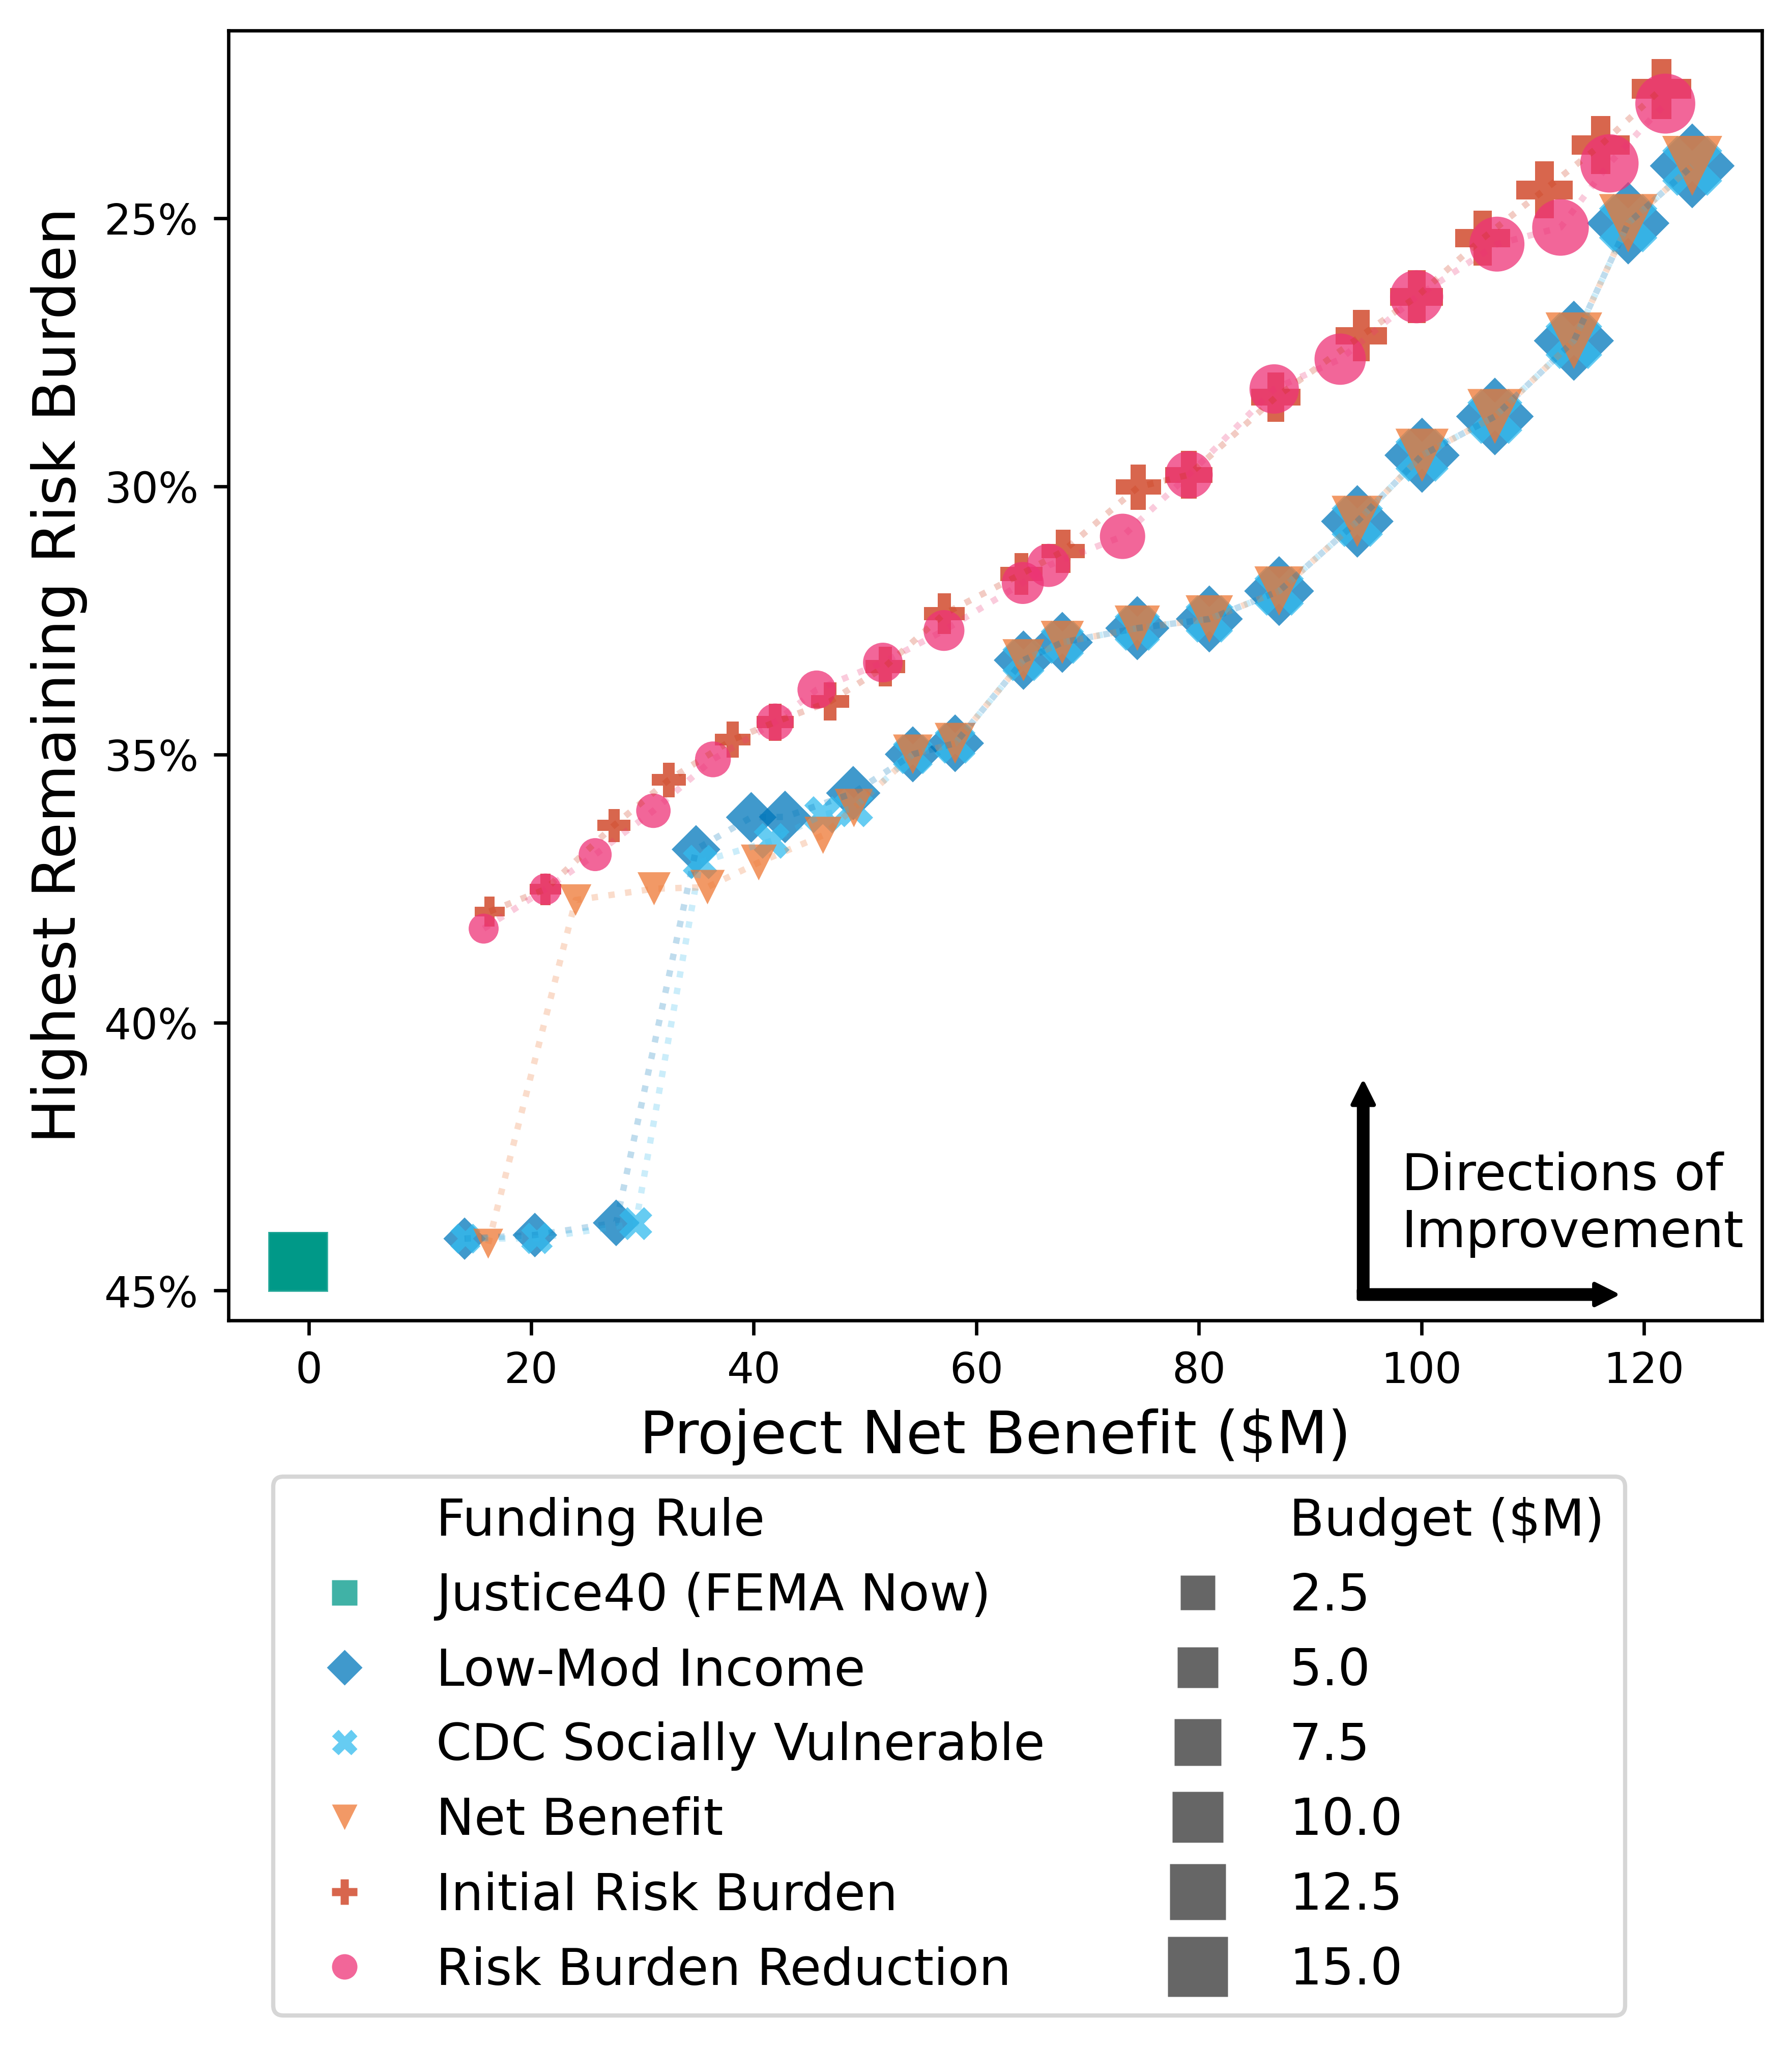

In [8]:
scen = 'Mid'

color_dict = {
    'CDC Socially Vulnerable': "#33BBEE",
    'Low-Mod Income': "#0077BB",
    'Justice40 (FEMA Now)': "#009988",
    'Risk Burden Reduction': "#EE3377",
    'Initial Risk Burden': "#CC3311",
    'Net Benefit': "#EE7733",
}

sort_dict = {
    'cejst': 'Justice40 (FEMA Now)',
    'lmi': 'Low-Mod Income',
    'sovi': 'CDC Socially Vulnerable',
    'npv_opt': 'Net Benefit',
    'rel_eal': 'Initial Risk Burden',
    'avoid_rel_eal': 'Risk Burden Reduction'
}

order_dict = {
    'cejst': 0,
    'lmi': 1,
    'sovi': 2,
    'npv_opt': 3,
    'rel_eal': 4,
    'avoid_rel_eal': 5
}

markers_dict = {
    'CDC Socially Vulnerable': "X",
    'Low-Mod Income': "D",
    'Justice40 (FEMA Now)': "s",
    'Risk Burden Reduction': "o",
    'Initial Risk Burden': "P",
    'Net Benefit': "v",
}

objs_plot = objs[(objs['sort'] != 'ovb') &
                 (objs['scen'] == scen)]

# Prep plot colums
objs_plot["npv_plot"] = objs_plot["npv"] / 1e6
objs_plot["avoid_eq1_plot"] = objs_plot["avoid_eq1"] * 100
objs_plot["Upfront Cost ($M)"] = objs_plot["up_cost"]/1e6
objs_plot["Budget ($M)"] = objs_plot["budget"]/1e6
objs_plot["Funding Rule"] = objs_plot['sort'].map(sort_dict)
objs_plot["order"] = objs_plot['sort'].map(order_dict)
objs_plot = objs_plot.sort_values(['order', 'budget'])

# objs_plot = objs_plot[objs_plot['sort'] != 'cejst']

fig, ax = plt.subplots(figsize=(6, 5), ncols=1,
                       dpi=600)

# Loop through each value in 'sort'
# Plot the kde
# Solid lines community, dashed for household
# Unique colors
lw = 2

# Plot boxplots for each policy besides Justice40
sns.lineplot(
    y='avoid_eq1_plot',
    x='npv_plot',
    data=objs_plot,
    hue="Funding Rule",
    palette=color_dict,
    # lw=lw,
    legend=False,
    ls='dotted',
    alpha=.25,
    ax=ax,
)

sns.scatterplot(
    y='avoid_eq1_plot',
    x='npv_plot',
    data=objs_plot,
    hue="Funding Rule",
    palette=color_dict,
    # lw=lw,
    style="Funding Rule",
    size="Budget ($M)",
    sizes=(50, 200),
    alpha=.75,
    markers=markers_dict,
    edgecolor='none',
    legend=True,
    ax=ax,
)

ax.set_xlabel("Project Net Benefit ($M)", size=14)

# Set y label
ax.set_ylabel("Highest Remaining Risk Burden", size=14)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

# These are minimize objectives, so reverse y-axis
ax.set_ylim(ax.get_ylim()[::-1])

# Arrows for directions of improvement
ax.annotate(
    "Directions of\nImprovement",
    xy=(0.765, 0.09),
    xycoords="axes fraction",
    xytext=(0.765, 0.09),
    textcoords="axes fraction",
    fontsize=12,
    color="black",
    horizontalalignment="left",
    verticalalignment="center",
)
ax.annotate(
    "",
    xytext=(0.74, 0.015),
    xy=(0.74, 0.19),
    xycoords="axes fraction",
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="simple", color="black"),
)
ax.annotate(
    "",
    xytext=(0.7316, 0.02),
    xy=(0.91, 0.02),
    xycoords="axes fraction",
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="simple", color="black"),
)


fig.tight_layout()


ax.legend(
    # handles=legend_elements,
    loc="center",
    ncol=2,
    fontsize="large",
    bbox_to_anchor=(.47, -0.33),
)

save_filename = join(FIG_DIR, 'Figure5',
                             scen + '_full_budget.png')
unfile.prepare_saving(save_filename)
fig.savefig(save_filename, bbox_inches='tight', dpi=600)



In [ ]:
color_dict = {
    'CDC Socially Vulnerable': "#33BBEE",
    'Low-Mod Income': "#0077BB",
    'Justice40 (FEMA Now)': "#009988",
    'Risk Burden Reduction': "#EE3377",
    'Initial Risk Burden': "#CC3311",
    'Net Benefit': "#EE7733",
}

sort_dict = {
    'cejst': 'Justice40 (FEMA Now)',
    'lmi': 'Low-Mod Income',
    'sovi': 'CDC Socially Vulnerable',
    'npv_opt': 'Net Benefit',
    'rel_eal': 'Initial Risk Burden',
    'avoid_rel_eal': 'Risk Burden Reduction'
}

order_dict = {
    'cejst': 0,
    'lmi': 1,
    'sovi': 2,
    'npv_opt': 3,
    'rel_eal': 4,
    'avoid_rel_eal': 5
}

markers_dict = {
    'CDC Socially Vulnerable': "X",
    'Low-Mod Income': "D",
    'Justice40 (FEMA Now)': "s",
    'Risk Burden Reduction': "o",
    'Initial Risk Burden': "P",
    'Net Benefit': "v",
}

fig, ax = plt.subplots(figsize=(6, 10), ncols=1,
                            sharex=True,
                            nrows=3,
                            dpi=600)

for i, scen in enumerate(SCENARIOS):
    scenario = scen

    objs_plot = objs[(objs['sort'] != 'ovb') &
                     (objs['budget'] < 7e6) &
                     (objs['scen'] == scenario)]

    # Prep plot colums
    objs_plot["npv_plot"] = objs_plot["npv"] / 1e6
    objs_plot["avoid_eq1_plot"] = objs_plot["avoid_eq1"] * 100
    objs_plot["Upfront Cost ($M)"] = objs_plot["up_cost"]/1e6
    objs_plot["Budget ($M)"] = objs_plot["budget"]/1e6
    objs_plot["Funding Rule"] = objs_plot['sort'].map(sort_dict)
    objs_plot["order"] = objs_plot['sort'].map(order_dict)
    objs_plot = objs_plot.sort_values(['order', 'budget'])

    # Loop through each value in 'sort'
    # Plot the kde
    # Solid lines community, dashed for household
    # Unique colors
    lw = 2

    ax[i].set_title("Hazard Scenario: " + scen, size=14)

    # Plot boxplots for each policy besides Justice40
    sns.lineplot(
        y='avoid_eq1_plot',
        x='npv_plot',
        data=objs_plot,
        hue="Funding Rule",
        palette=color_dict,
        # lw=lw,
        legend=False,
        ls='dotted',
        alpha=.25,
        ax=ax[i],
    )
    sns.scatterplot(
        y='avoid_eq1_plot',
        x='npv_plot',
        data=objs_plot,
        hue="Funding Rule",
        palette=color_dict,
        # lw=lw,
        style="Funding Rule",
        size="Budget ($M)",
        sizes=(50, 200),
        alpha=.75,
        markers=markers_dict,
        edgecolor='none',
        legend=True,
        ax=ax[i],
    )

    ax[i].set_xlabel("Project Net Benefit ($M)", size=14)
    ax[i].set_ylabel('')
    ax[i].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    ax[i].set_ylim(ax[i].get_ylim()[::-1])

    # Arrows for directions of improvement
    ax[i].annotate(
        "Directions of\nImprovement",
        xy=(0.765, 0.11),
        xycoords="axes fraction",
        xytext=(0.765, 0.11),
        textcoords="axes fraction",
        fontsize=12,
        color="black",
        horizontalalignment="left",
        verticalalignment="center",
    )
    ax[i].annotate(
        "",
        xytext=(0.74, 0.015),
        xy=(0.74, 0.21),
        xycoords="axes fraction",
        textcoords="axes fraction",
        arrowprops=dict(arrowstyle="simple", color="black"),
    )
    ax[i].annotate(
        "",
        xytext=(0.7316, 0.02),
        xy=(0.87, 0.02),
        xycoords="axes fraction",
        textcoords="axes fraction",
        arrowprops=dict(arrowstyle="simple", color="black"),
    )

ax[1].set_ylabel("Inequality in Residual Risk Burden", size=14)

ax[0].legend_.remove()
ax[1].legend_.remove()

fig.tight_layout()

ax[2].legend(
    loc="center",
    ncol=2,
    fontsize="large",
    bbox_to_anchor=(.47, -0.62),
)

save_filename = join(FIG_DIR, 'Figure5',
                              'hazard_scenario_sensitivities.png')
unfile.prepare_saving(save_filename)
fig.savefig(save_filename, bbox_inches='tight', dpi=600)

# Checking SFHA against risk burden estimates

In [ ]:
# Get flood zones linked up
ens_mid_fz = ens_agg_dfs['Mid'].merge(nsi_fz, on='fd_id')
ens_mid_fz = ens_mid_fz.sort_values('rel_eal')

# Get ref ids linked up
ens_mid_fz = ens_mid_fz.merge(nsi_ref, on='fd_id')

# Can plot nfip policy count per year as a background to the
# risk burden estimates. Can also plot nfip policy count per year
# as a background to properties in/out SFHA

# Get flood zones linked up
ens_mid_fz = ens_agg_dfs['Mid'].merge(nsi_fz, on='fd_id')
ens_mid_fz = ens_mid_fz.sort_values('rel_eal')

# Get ref ids linked up
ens_mid_fz = ens_mid_fz.merge(nsi_ref, on='fd_id')

cmap_eal_l = ['#FEDA8B', '#FDB366',
              '#F67E4B', '#DD3D2D', '#A50026']
cmap_eal = mpc.LinearSegmentedColormap.from_list("", cmap_eal_l)

risk_cmap = cmap_eal
tracts = tract_geo.to_crs(3857)

ens_mid_fz["rel_eal_plot"] = np.round(ens_mid_fz["rel_eal"] * 100)

sfha = fz_geo[fz_geo['fld_zone'].isin(['A', 'AE'])]
sfha_clip = sfha.clip(clip_geo)
sfha_clip = sfha_clip.to_crs(3857)
ens_mid_fz = ens_mid_fz.to_crs(3857)

# Plot risk burden points with number policies background
fig, ax = plt.subplots(figsize=(10, 6), dpi=600)

tracts.plot(ax=ax, edgecolor="black", color="none", lw=1)
# pols_bg.plot(ax=ax, column='n', cmap='Blues', legend=False)
sfha_clip.plot(ax=ax, color="red", alpha=.25)

vmin_eal = 0
vmax_eal = ens_mid_fz["rel_eal_plot"].max()
# Sort before plotting
ens_mid_fz = ens_mid_fz.sort_values("rel_eal_plot", ascending=True)
ens_mid_fz.plot(
                ax=ax,
                column="rel_eal_plot",
                cmap=risk_cmap,
                s=2,
                vmin=vmin_eal,
                vmax=vmax_eal,
                )

cx.add_basemap(ax,
               attribution_size=4,
               source=cx.providers.Esri.WorldImagery)

# Set axis off but keep outline
ax.tick_params(
    axis="both",
    which="both",
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False,
)

ax.axis('off')

legend_elements = [
        Patch(facecolor="red", 
              alpha=0.25, label="Special Flood Hazard Area")
    ]

ax.legend(
    handles=legend_elements,
    loc="center",
    fontsize="small",
    bbox_to_anchor=(0.8, 0.91),
    #frameon=False,
)

# Add continuous legends
cax = fig.add_axes([0.28, 0.05, 0.48, 0.02])
sm = plt.cm.ScalarMappable(
    cmap=risk_cmap, norm=plt.Normalize(vmin=vmin_eal, vmax=vmax_eal)
)
sm._A = []
cbr = fig.colorbar(
    sm,
    cax=cax,
    orientation="horizontal",
    format=ticker.PercentFormatter(decimals=0),
)
cbr.ax.tick_params(labelsize=12)
cbr.set_label("Risk Burden (%)", size=12)

save_filename = join(FIG_DIR,
                     'fldzones_satellite_burden.png')
unfile.prepare_saving(save_filename)
fig.savefig(save_filename, dpi=600, bbox_inches="tight")